In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

           positive      negative       pending  hospitalized       death  \
count   1146.000000   1013.000000    386.000000    124.000000  477.000000   
mean     307.695462   2087.684107    433.727979    230.467742    9.941300   
std     1871.650381   6047.114256   3913.742528    809.672015   29.445733   
min        0.000000      0.000000     -3.000000      0.000000    0.000000   
25%        3.000000     59.000000      4.000000      9.500000    1.000000   
50%       24.000000    271.000000     20.500000     39.500000    2.000000   
75%      123.750000   1544.000000     82.000000     96.000000    7.000000   
max    37258.000000  84846.000000  57400.000000   6844.000000  385.000000   

               total  totalTestResults  deathIncrease  hospitalizedIncrease  \
count    1149.000000       1149.000000    1093.000000           1093.000000   
mean     2293.178416       2147.469974       1.064959              9.269899   
std      7983.651430       7399.096875       5.719511            110.

### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-03-24_1744_state_daily_data.csv 2020-03-26_1419_state_daily_data.csv
2020-03-24_1744_state_rank.csv       2020-03-26_1419_state_rank.csv
2020-03-24_1829_state_daily_data.csv 2020-03-26_1604_state_daily_data.csv
2020-03-24_1829_state_rank.csv       2020-03-26_1604_state_rank.csv
2020-03-24_2013_state_daily_data.csv 2020-03-26_1748_state_daily_data.csv
2020-03-24_2013_state_rank.csv       2020-03-26_1748_state_rank.csv
2020-03-24_2046_state_daily_data.csv 2020-03-26_2209_state_daily_data.csv
2020-03-24_2046_state_rank.csv       2020-03-26_2209_state_rank.csv
2020-03-24_2359_state_daily_data.csv 2020-03-26_2303_state_daily_data.csv
2020-03-24_2359_state_rank.csv       2020-03-26_2303_state_rank.csv
2020-03-25_0000_state_daily_data.csv 2020-03-27_0119_state_daily_data.csv
2020-03-25_0000_state_rank.csv       2020-03-27_0119_state_rank.csv
2020-03-25_1516_state_daily_data.csv 2020-03-27_0124_state_daily_data.csv
2020-03-25_1516_state_rank.csv       2020-03-27_0124_state_rank.csv
2020-0

In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,78,2020-03-04 21:00:00+00:00,54,NaN,NaN,NaN,NaN,NaN,0,2020-03-26 16:59:00
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,122,2020-03-05 21:00:00+00:00,98,0.0,0.0,28.0,16.0,44.0,0,2020-03-26 16:59:00
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,361,2020-03-06 21:00:00+00:00,125,0.0,0.0,16.0,11.0,27.0,0,2020-03-26 16:59:00
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,404,2020-03-07 21:00:00+00:00,168,0.0,0.0,0.0,43.0,43.0,0,2020-03-26 16:59:00
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,197,2020-03-08 20:00:00+00:00,197,0.0,0.0,0.0,29.0,29.0,0,2020-03-26 16:59:00


### Zero-day normalized log plots

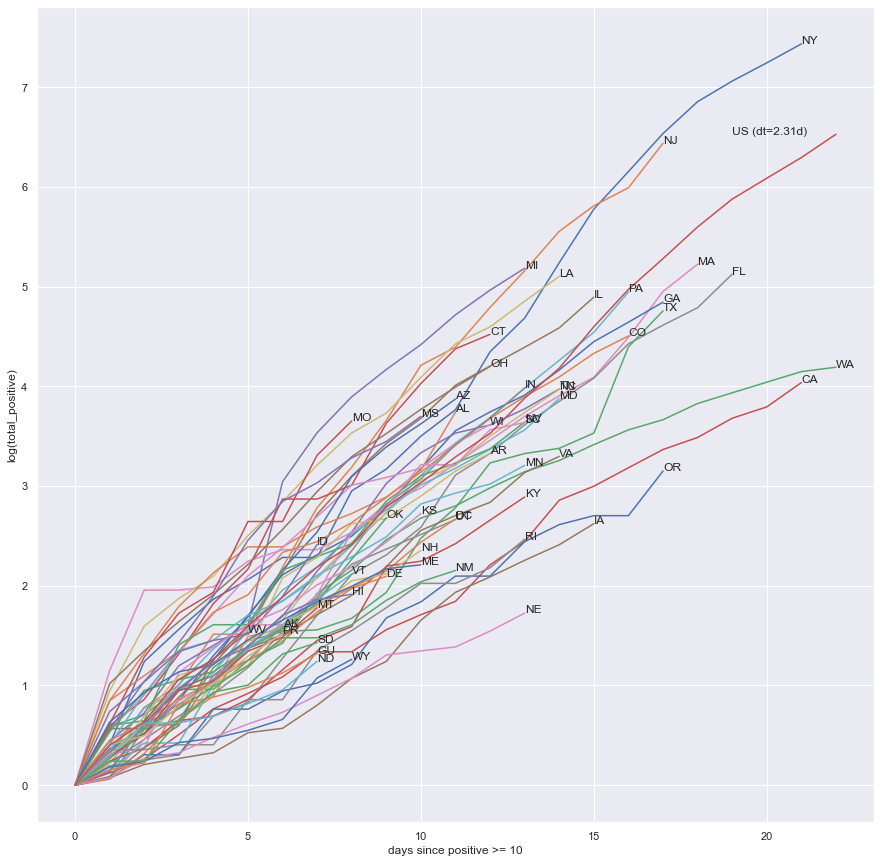

In [7]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

# state by state
for s in states_in_order:
    try:
        dfq, dt, lud = get_state_doubling_df(df, s, zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
        plt.annotate(s, (dfq["days_since_{}".format(min_pos)].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:
    dfq, dt, lud = get_state_doubling_df(df, "*", zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
    xus = int(.9* dfq["days_since_{}".format(min_pos)].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Totals and Doubling Times

US Total Positive, doubling every 2.28 days
  as of 2020-03-27T10:00
  based on last 14 days of data


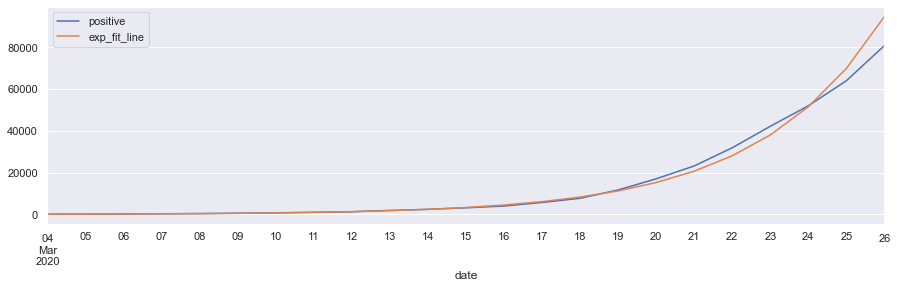

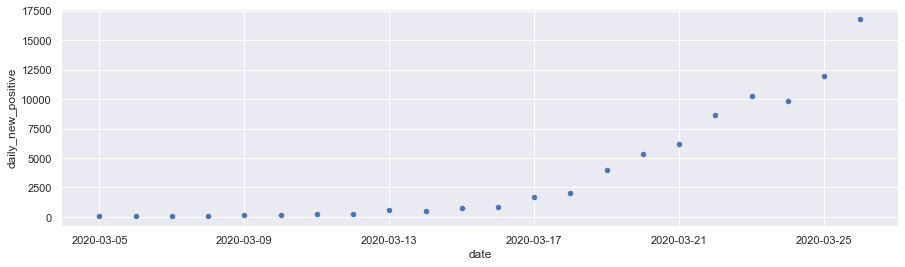

In [8]:
last_n_days = 14
dfa, dt, lud = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(lud)[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

### Testing

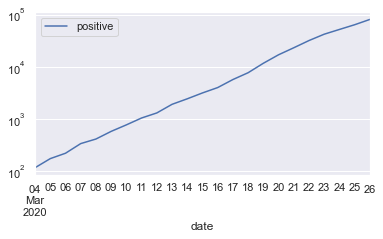

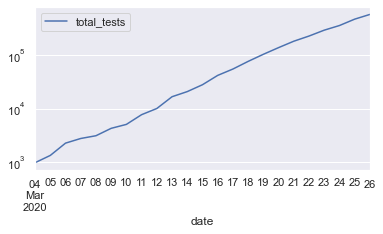

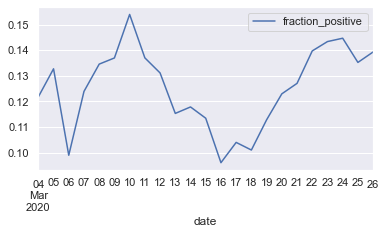

In [9]:
dfs, _ = get_state_df(df, "*")
dfs.head()
dfs["total_tests"] = dfs["positive"] + dfs["negative"] + dfs["pending"]
dfs["fraction_positive"] = dfs["positive"]/ dfs["total_tests"]
dfa.plot(x="date", y="positive", logy=True, figsize=[6,3])
dfs.plot("date", "total_tests", logy=True, figsize=[6,3])
dfs.plot("date", "fraction_positive", figsize=[6,3])

### Model of acutal infections with set perscentage of symptomatic or untested

MODEL: US Total Positive, doubling every 2.23 days
(2020-03-27T10:00)


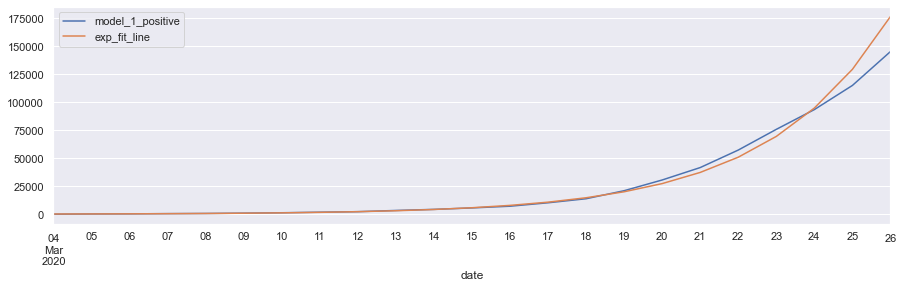

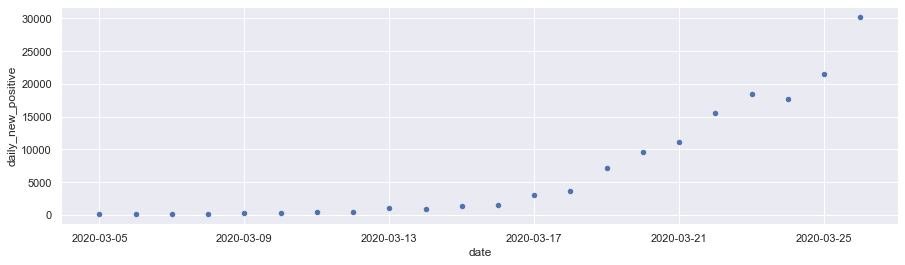

In [10]:
# model of acutals
dfm = model_1_actual_infections(dfa, "*")
dfma, dtm, _ = get_state_doubling_df(dfm, "*", pos_key="model_1_positive")
dfma.plot(x="date", y=["model_1_positive", "exp_fit_line"], figsize=[15,4])
lu = str(lud)[:16]
print("MODEL: US Total Positive, doubling every {:.3} days\n({})".format(dtm, lu))
dfma.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

### Current measured ratios and percentages

These are based on cases that test postive and test negative (state labs policies vary on this).

In [11]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    df.positive.sum()/(df.positive.sum() + df.negative.sum())))
print("on total tests tracked = {:,}".format(int(df.positive.sum() + df.negative.sum())))

Current strategies for diagnosis give pos/neg tests ratio of 14.3%
on total tests tracked = 2,467,443


In [12]:
pos_dr = df.death.sum()/df.positive.sum()
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 1.3%


In [13]:
# projections of exp growth
print("US flu death rate average per month = 61,099/12 ≈ {}".format(int(61099/12)))
print("Using doubling time of {:2.2f} days".format(dt))
print("period      date         positive,     deaths              weekly rate")
print("-------------------------------------------------------------------------------------")
now, v = dfa[-1:][["date", "positive"]].values[0]
start, _ = dfa[1:][["date", "positive"]].values[0]
time_in_weeks = (now - start).total_seconds()/(86400*7)
pstr = "{:4}: {:%Y-%m-%d %H h}, {:10,d} [total deaths {:6,d}] Death Rate Avg = {:,d} per wk"
print(pstr.format(0, now, int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))

ddt = datetime.timedelta(days=dt)
for i in range(1,5):
    t = now + i*ddt
    time_in_weeks = (t - start).total_seconds()/(86400*7)
    v *= 2
    print(pstr.format(i,t,int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))
    

US flu death rate average per month = 61,099/12 ≈ 5091
Using doubling time of 2.28 days
period      date         positive,     deaths              weekly rate
-------------------------------------------------------------------------------------
   0: 2020-03-26 00 h,     80,735 [total deaths  1,085] Death Rate Avg = 361 per wk
   1: 2020-03-28 06 h,    161,470 [total deaths  2,171] Death Rate Avg = 652 per wk
   2: 2020-03-30 13 h,    322,940 [total deaths  4,342] Death Rate Avg = 1,189 per wk
   3: 2020-04-01 20 h,    645,880 [total deaths  8,685] Death Rate Avg = 2,183 per wk
   4: 2020-04-04 02 h,  1,291,760 [total deaths 17,371] Death Rate Avg = 4,037 per wk


### State Trends and Doubling Periods

State=NY  (last_update=2020-03-26T16:59)
Doubling every 1.83 days based on last 14 days of data
(naive estimates: current_unresolved=36308 hosp=5446 icu=1452)


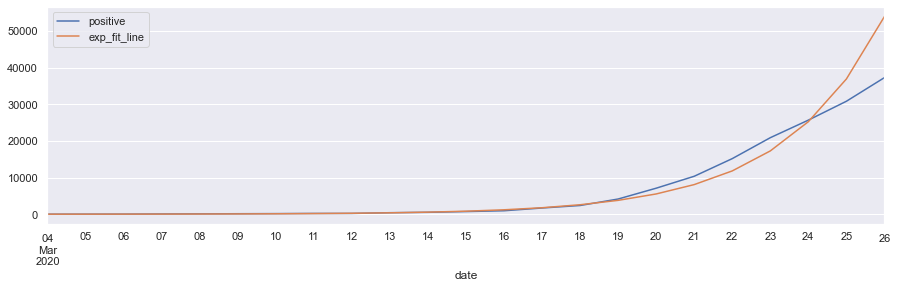

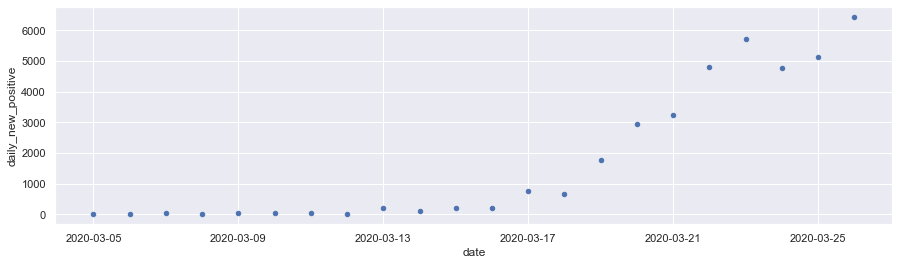

State=NJ  (last_update=2020-03-26T13:30)
Doubling every 1.76 days based on last 14 days of data
(naive estimates: current_unresolved=6698 hosp=1004 icu=267)


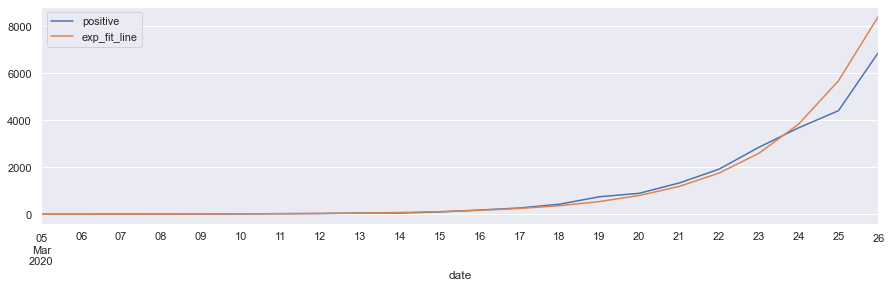

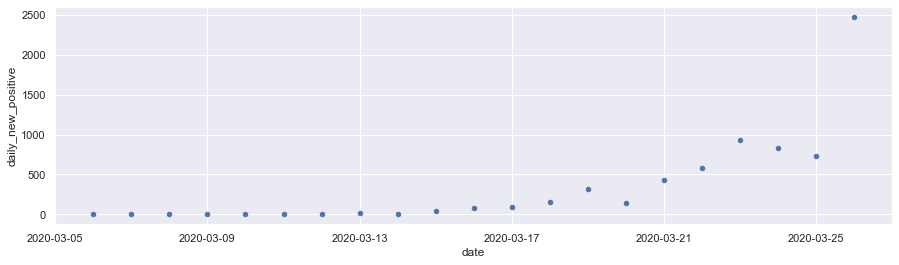

State=WA  (last_update=2020-03-26T18:45)
Doubling every 5.14 days based on last 14 days of data
(naive estimates: current_unresolved=1811 hosp=271 icu=72)


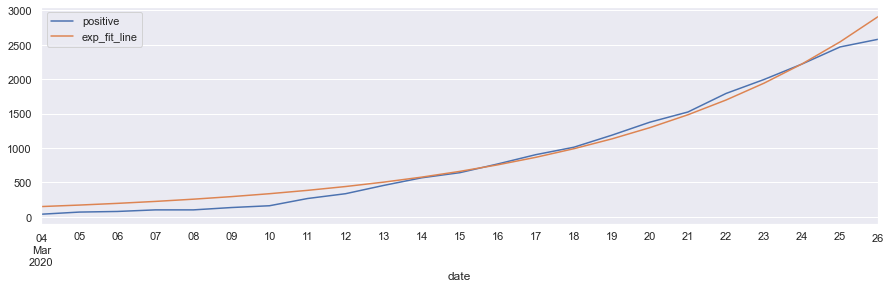

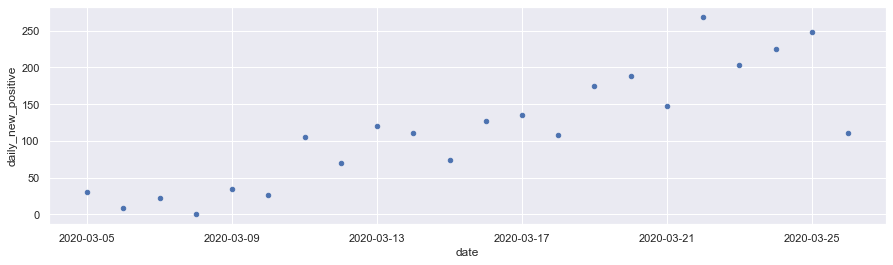

State=CA  (last_update=2020-03-25T17:00)
Doubling every 3.25 days based on last 14 days of data
(naive estimates: current_unresolved=2671 hosp=400 icu=106)


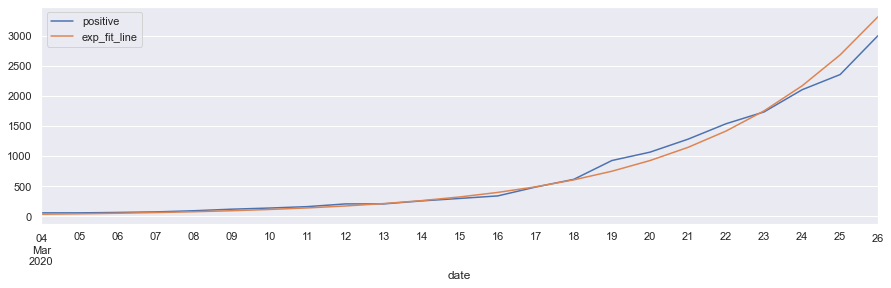

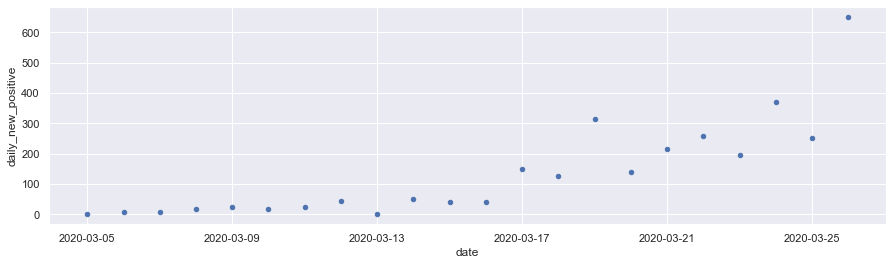

State=MI  (last_update=2020-03-26T11:00)
Doubling every 1.6 days based on last 14 days of data
(naive estimates: current_unresolved=2803 hosp=420 icu=112)


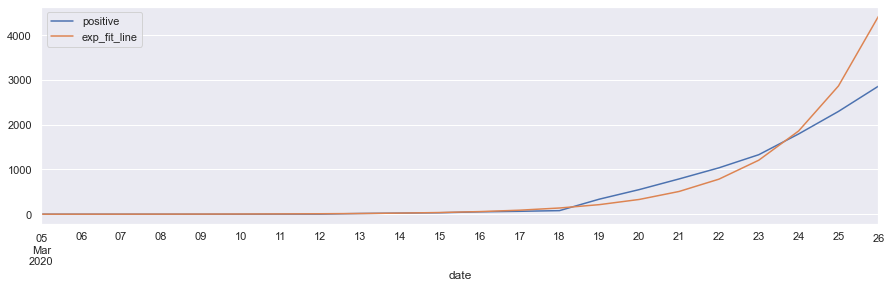

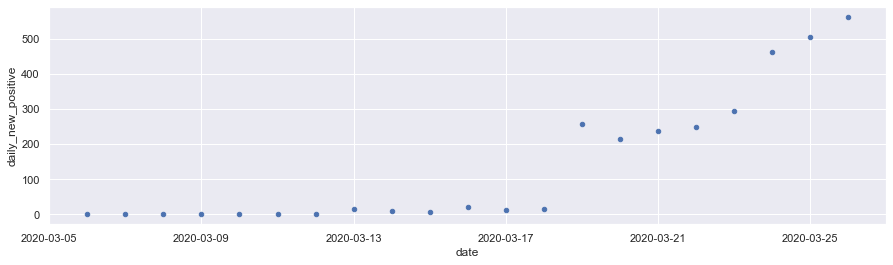

State=IL  (last_update=2020-03-26T00:00)
Doubling every 2.01 days based on last 14 days of data
(naive estimates: current_unresolved=2445 hosp=366 icu=97)


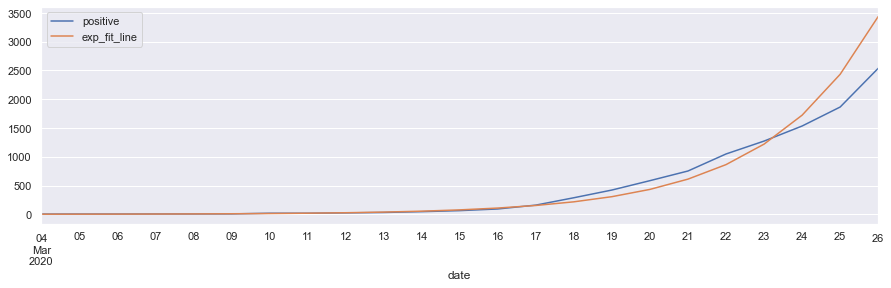

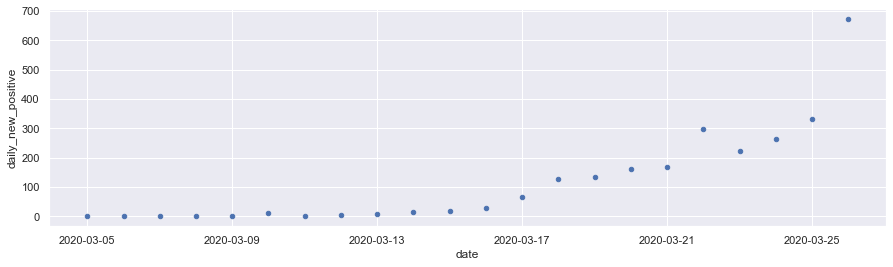

State=MA  (last_update=2020-03-26T12:30)
Doubling every 3.0 days based on last 14 days of data
(naive estimates: current_unresolved=2253 hosp=337 icu=90)


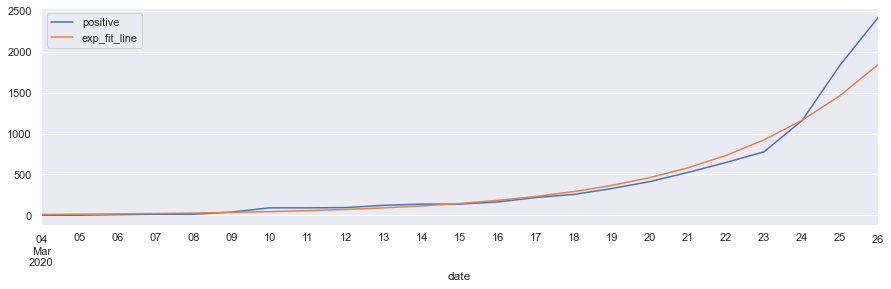

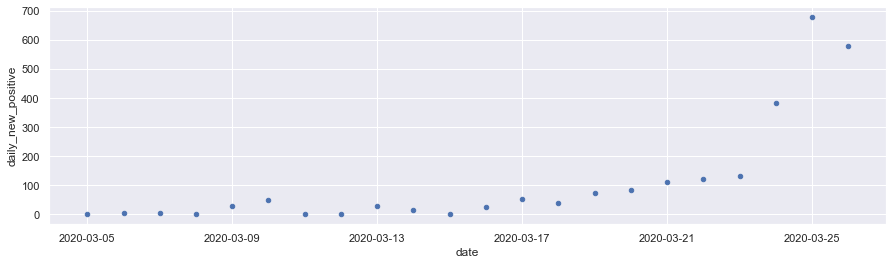

State=FL  (last_update=2020-03-26T11:00)
Doubling every 2.4 days based on last 14 days of data
(naive estimates: current_unresolved=2214 hosp=332 icu=88)


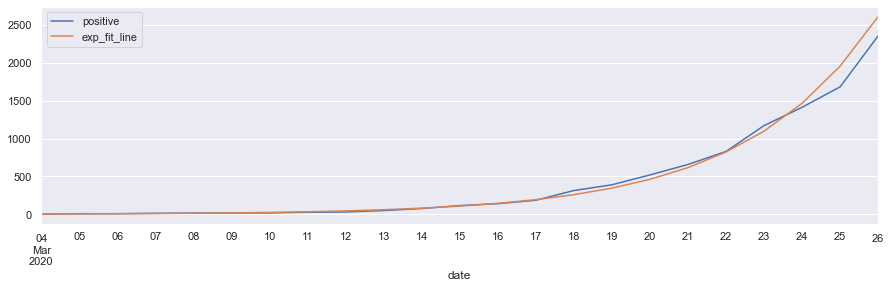

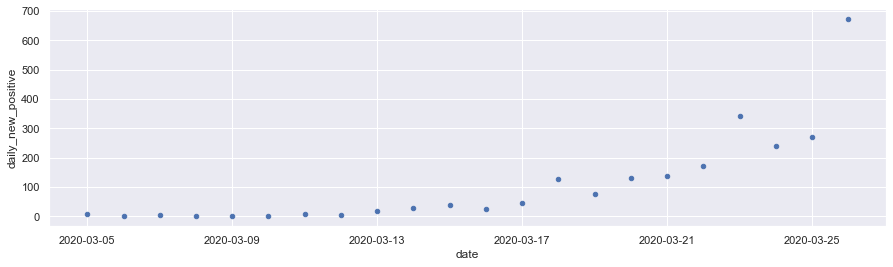

State=LA  (last_update=2020-03-26T15:00)
Doubling every 2.23 days based on last 14 days of data
(naive estimates: current_unresolved=2191 hosp=328 icu=87)


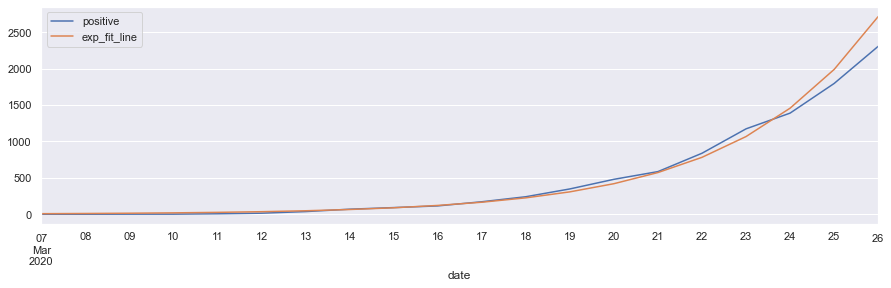

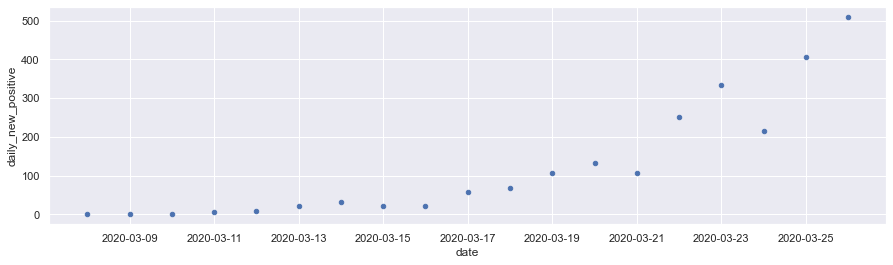

State=PA  (last_update=2020-03-26T12:00)
Doubling every 2.32 days based on last 14 days of data
(naive estimates: current_unresolved=1611 hosp=241 icu=64)


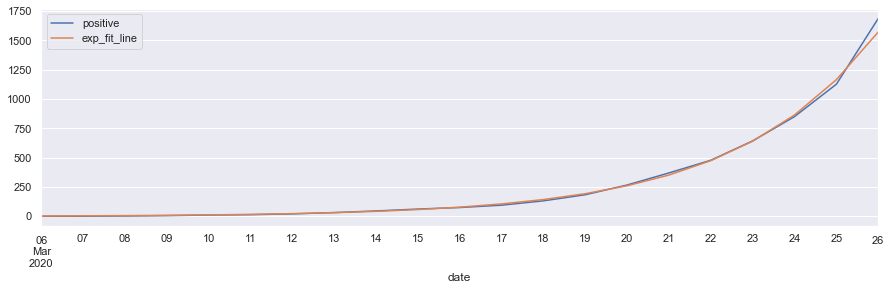

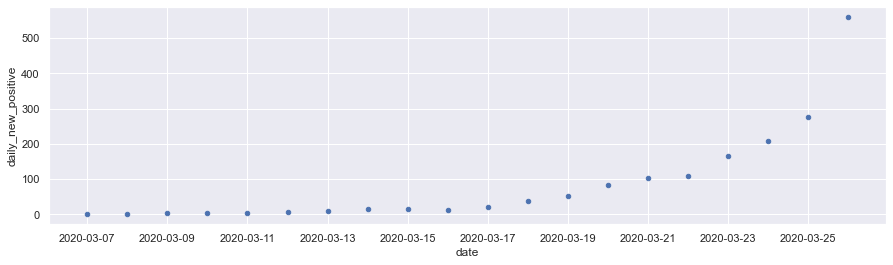

State=GA  (last_update=2020-03-26T19:00)
Doubling every 2.56 days based on last 14 days of data
(naive estimates: current_unresolved=1404 hosp=210 icu=56)


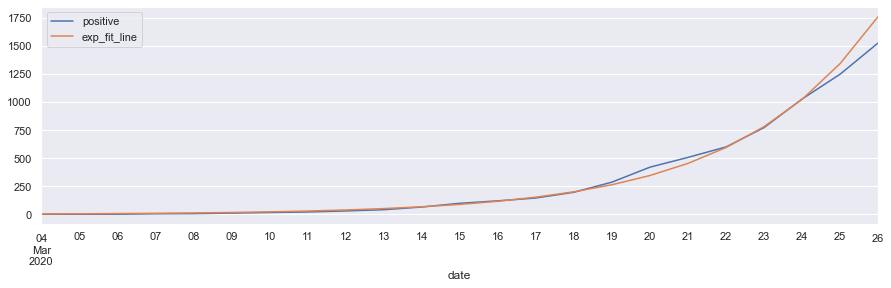

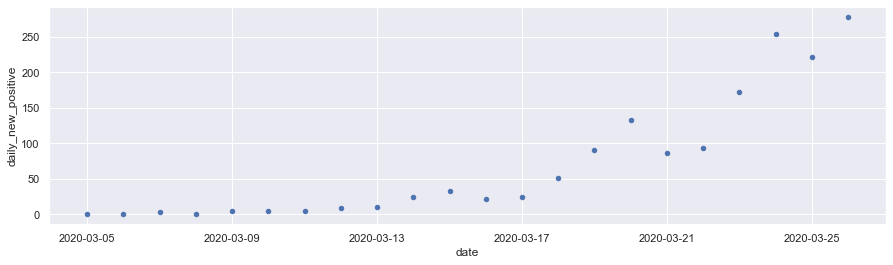

State=CO  (last_update=2020-03-26T18:00)
Doubling every 3.39 days based on last 14 days of data
(naive estimates: current_unresolved=955 hosp=143 icu=38)


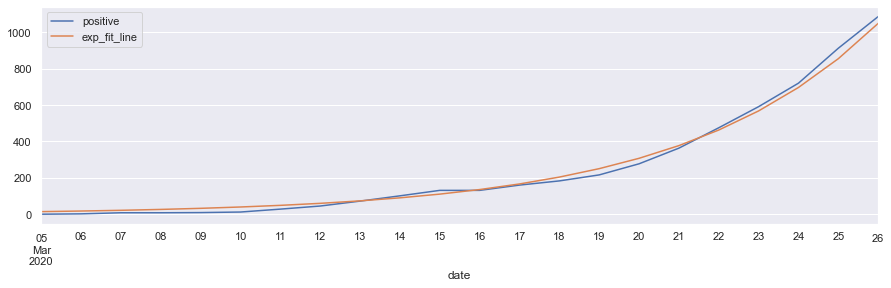

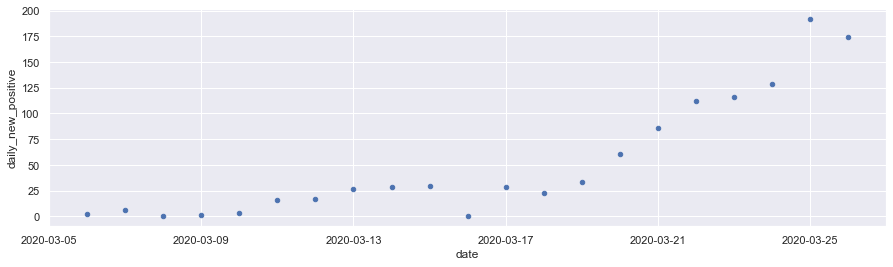

State=TX  (last_update=2020-03-26T13:00)
Doubling every 2.58 days based on last 14 days of data
(naive estimates: current_unresolved=1339 hosp=200 icu=53)


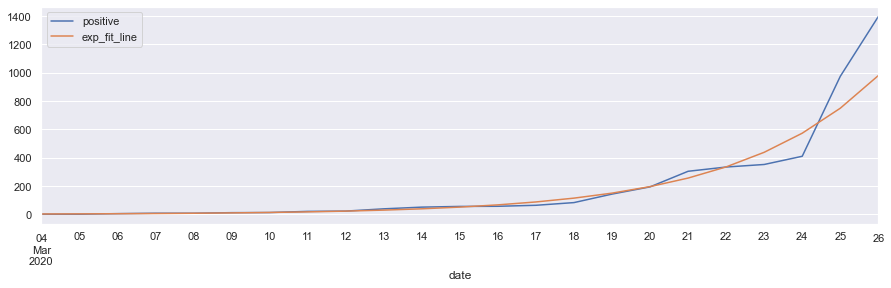

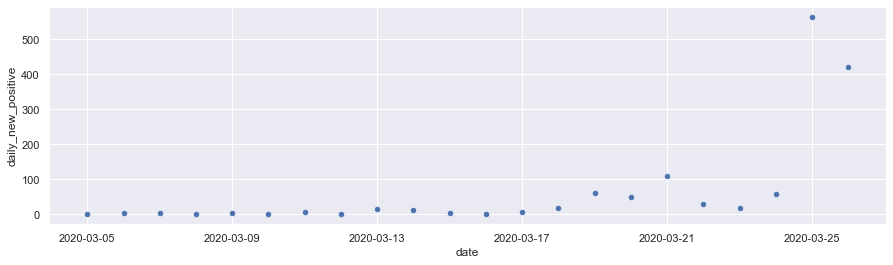

State=CT  (last_update=2020-03-26T13:30)
Doubling every 1.78 days based on last 14 days of data
(naive estimates: current_unresolved=986 hosp=147 icu=39)


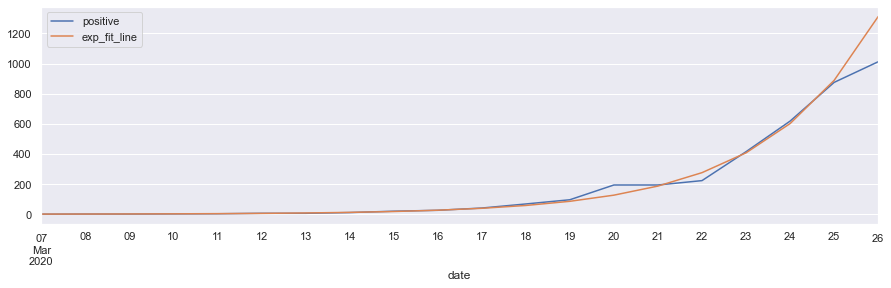

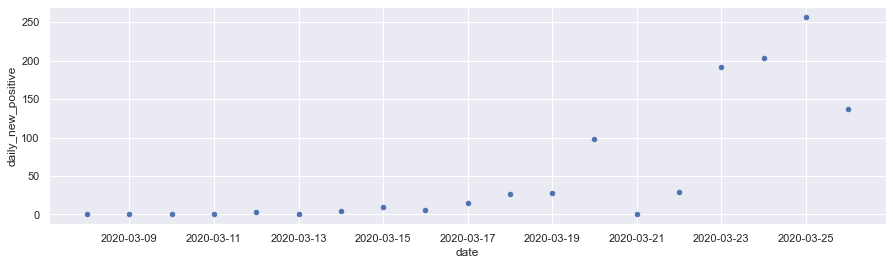

State=TN  (last_update=2020-03-26T15:00)
Doubling every 2.27 days based on last 14 days of data
(naive estimates: current_unresolved=905 hosp=135 icu=36)


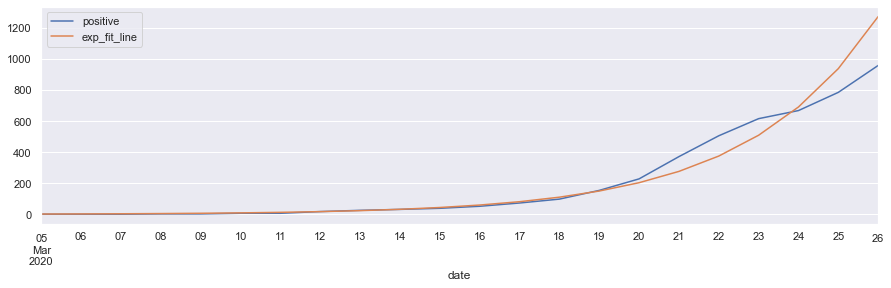

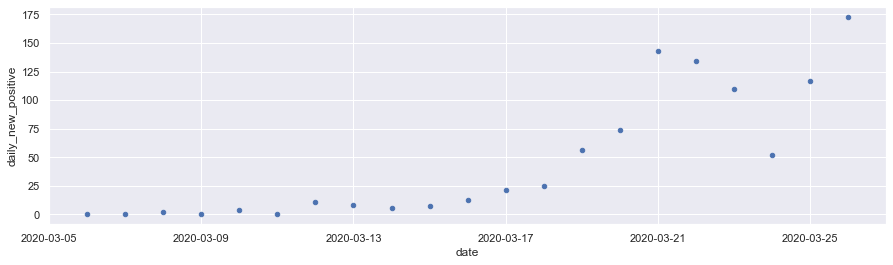

State=OH  (last_update=2020-03-26T14:00)
Doubling every 2.1 days based on last 14 days of data
(naive estimates: current_unresolved=817 hosp=122 icu=32)


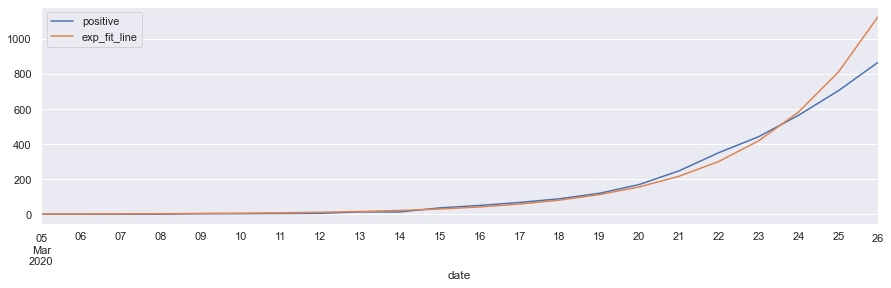

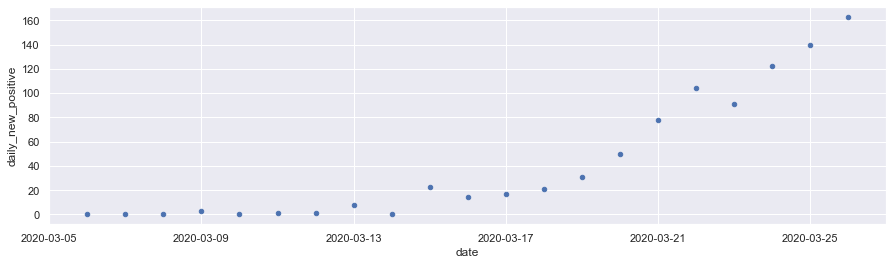

State=WI  (last_update=2020-03-26T16:00)
Doubling every 2.33 days based on last 14 days of data
(naive estimates: current_unresolved=660 hosp=99 icu=26)


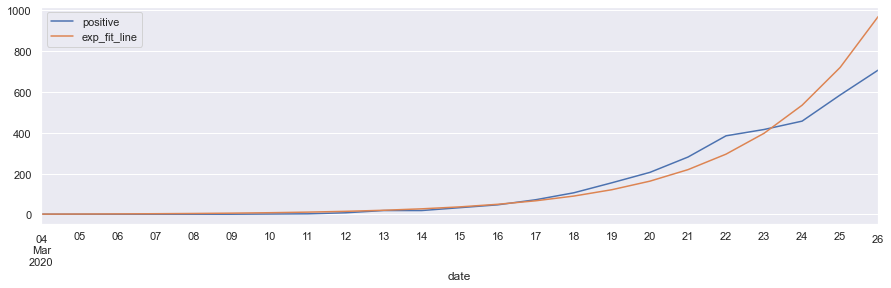

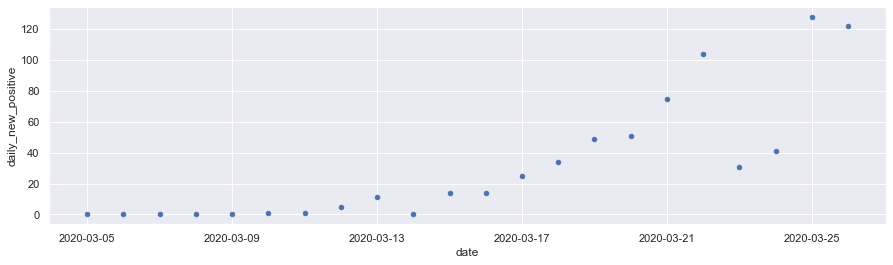

State=IN  (last_update=2020-03-25T12:59)
Doubling every 2.15 days based on last 14 days of data
(naive estimates: current_unresolved=621 hosp=93 icu=24)


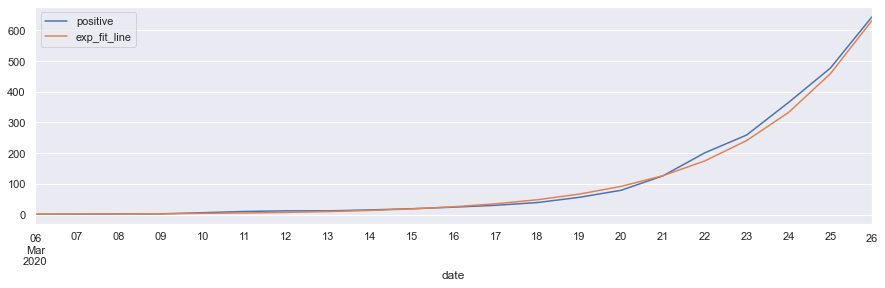

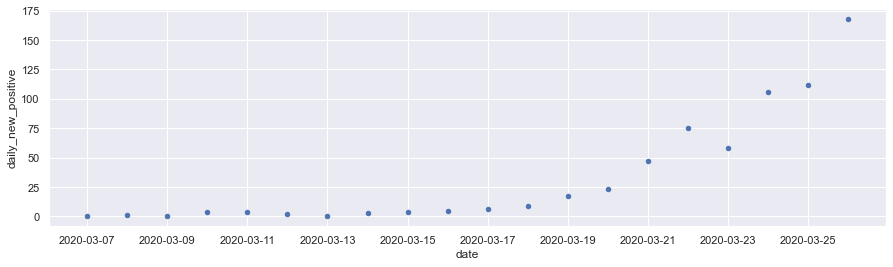

State=NC  (last_update=2020-03-26T12:36)
Doubling every 2.36 days based on last 14 days of data
(naive estimates: current_unresolved=603 hosp=90 icu=24)


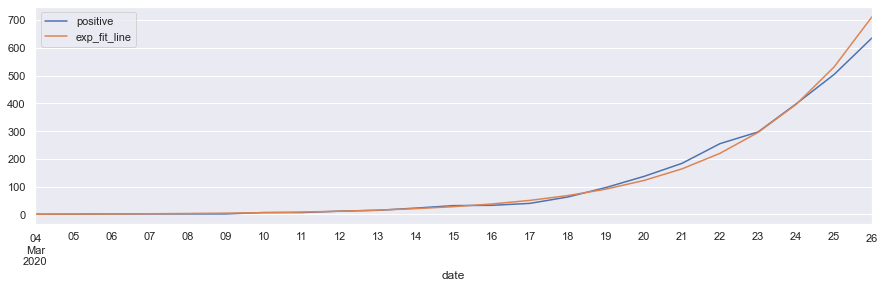

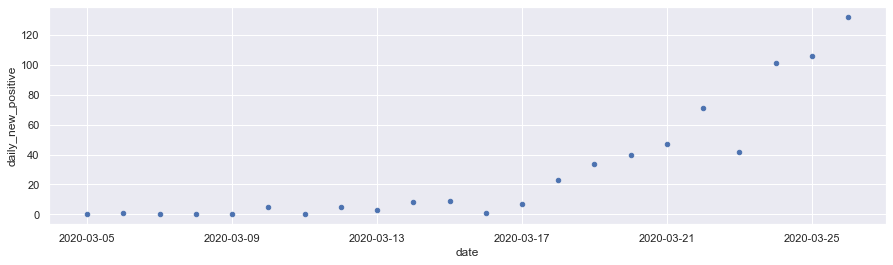

State=MD  (last_update=2020-03-26T10:00)
Doubling every 2.57 days based on last 14 days of data
(naive estimates: current_unresolved=543 hosp=81 icu=21)


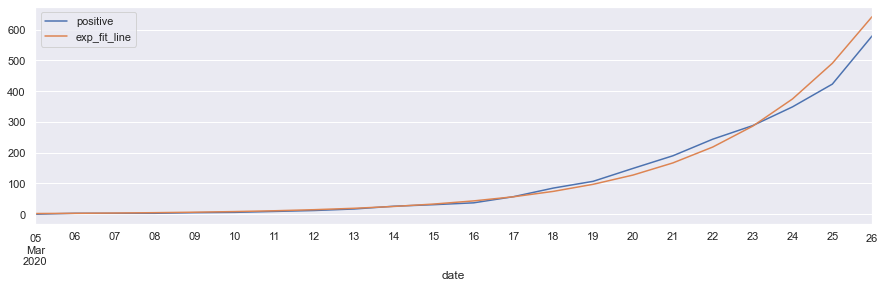

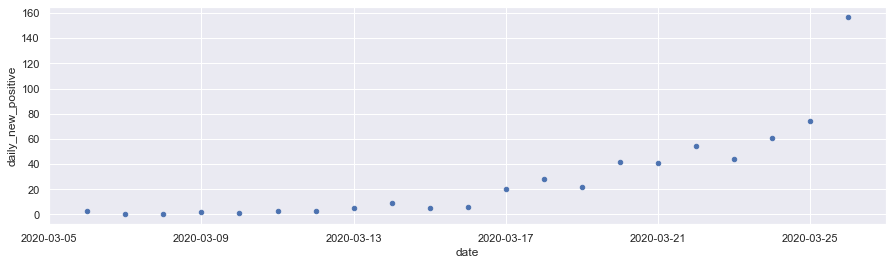

State=AZ  (last_update=2020-03-26T00:00)
Doubling every 2.0 days based on last 14 days of data
(naive estimates: current_unresolved=559 hosp=83 icu=22)


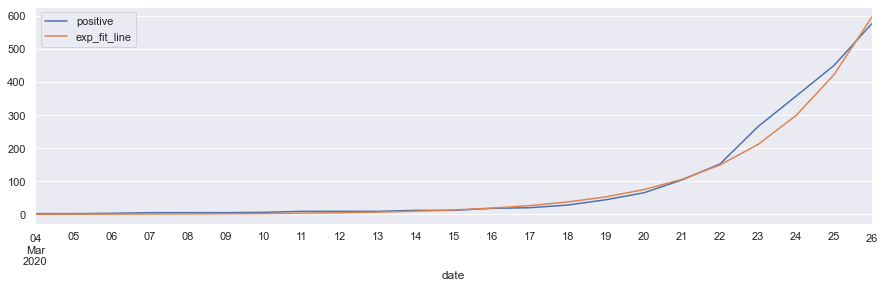

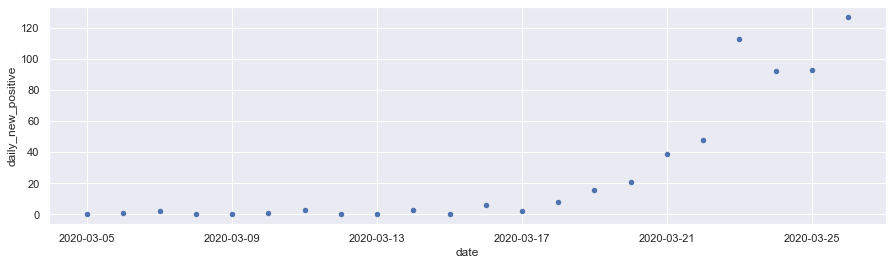

State=AL  (last_update=2020-03-27T00:00)
Doubling every 1.84 days based on last 14 days of data
(naive estimates: current_unresolved=478 hosp=71 icu=19)


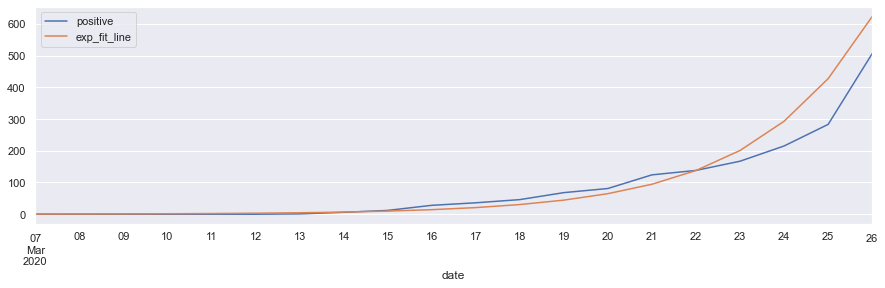

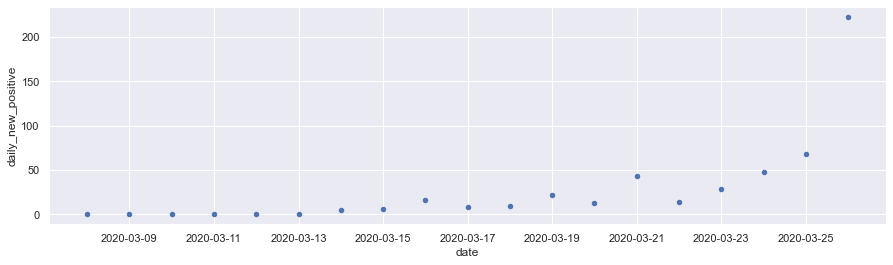

State=NV  (last_update=2020-03-26T23:00)
Doubling every 2.59 days based on last 14 days of data
(naive estimates: current_unresolved=375 hosp=56 icu=15)


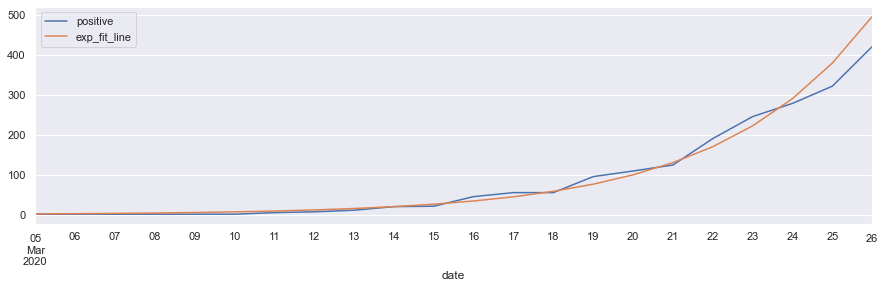

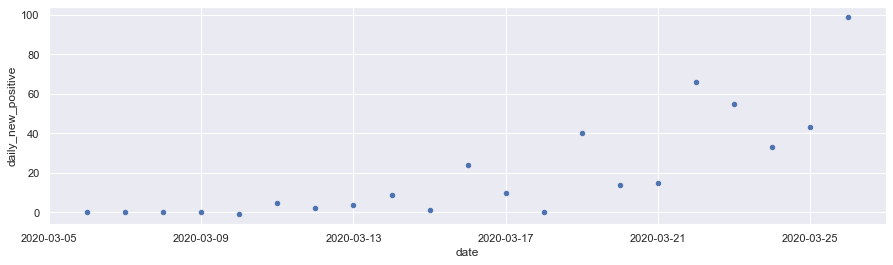

State=MO  (last_update=2020-03-26T15:00)
Doubling every 1.61 days based on last 14 days of data
(naive estimates: current_unresolved=496 hosp=74 icu=19)


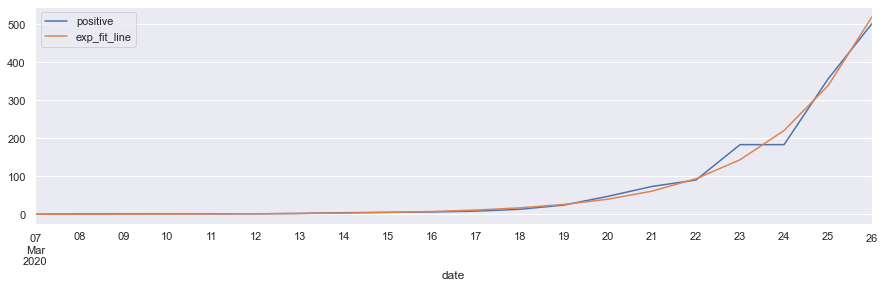

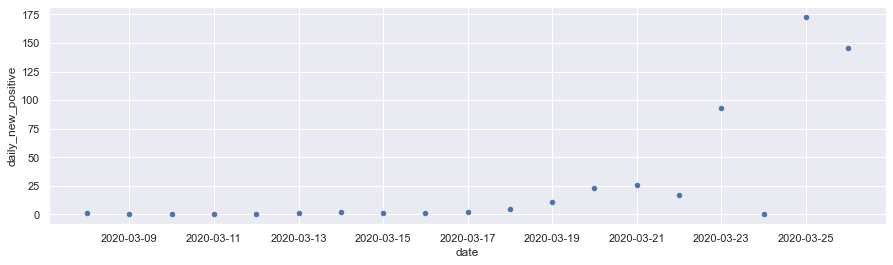

State=MS  (last_update=2020-03-26T00:00)
Doubling every 1.79 days based on last 14 days of data
(naive estimates: current_unresolved=473 hosp=70 icu=18)


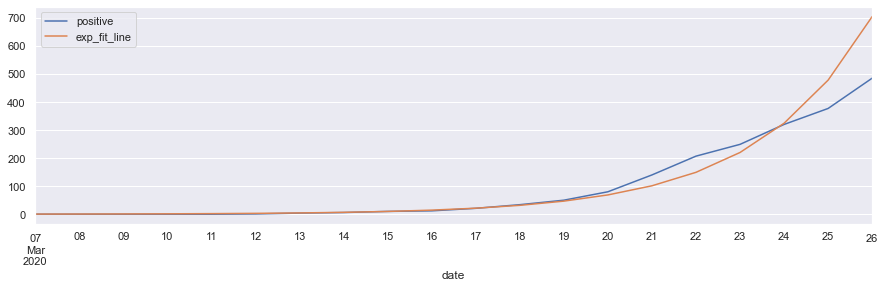

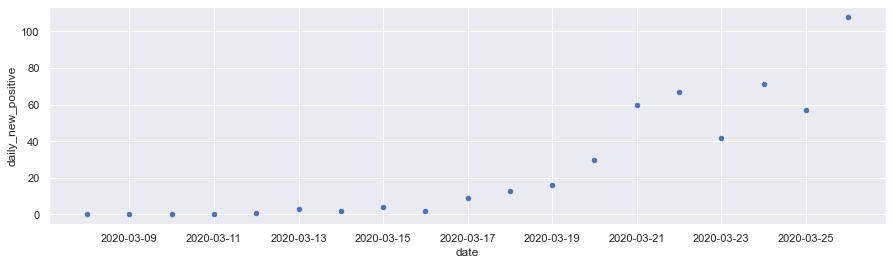

State=VA  (last_update=2020-03-26T00:00)
Doubling every 3.16 days based on last 14 days of data
(naive estimates: current_unresolved=409 hosp=61 icu=16)


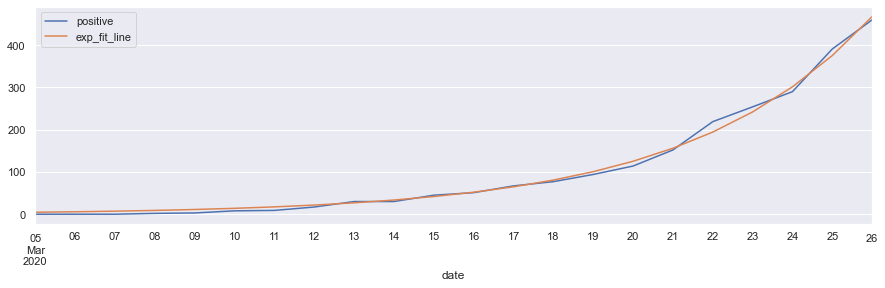

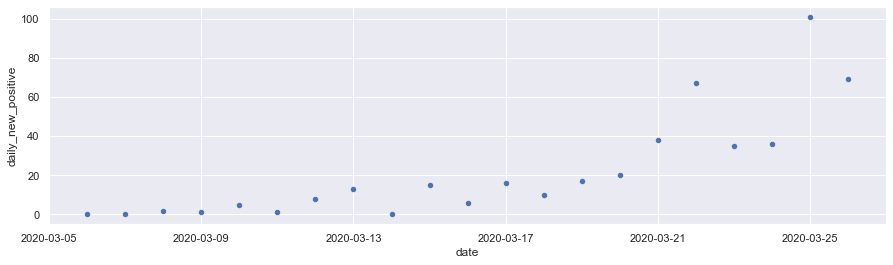

State=SC  (last_update=2020-03-26T11:00)
Doubling every 2.27 days based on last 14 days of data
(naive estimates: current_unresolved=428 hosp=64 icu=17)


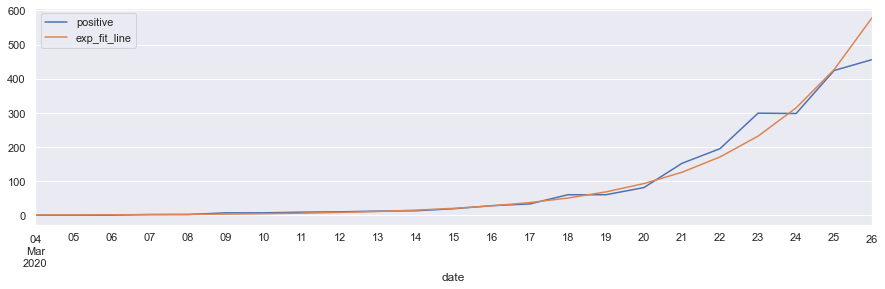

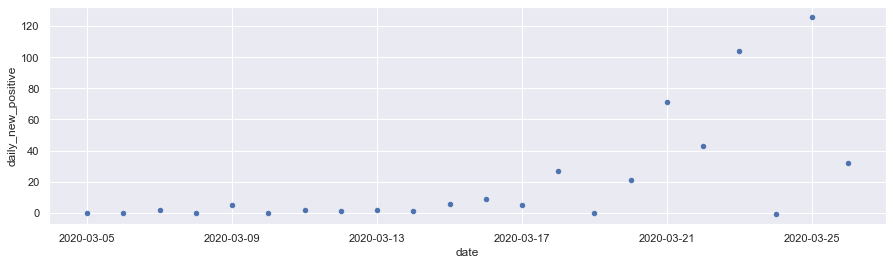

State=UT  (last_update=2020-03-26T15:00)
Doubling every 2.21 days based on last 14 days of data
(naive estimates: current_unresolved=363 hosp=54 icu=14)


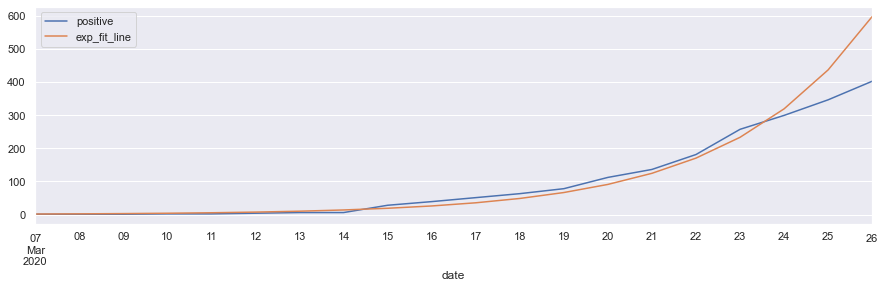

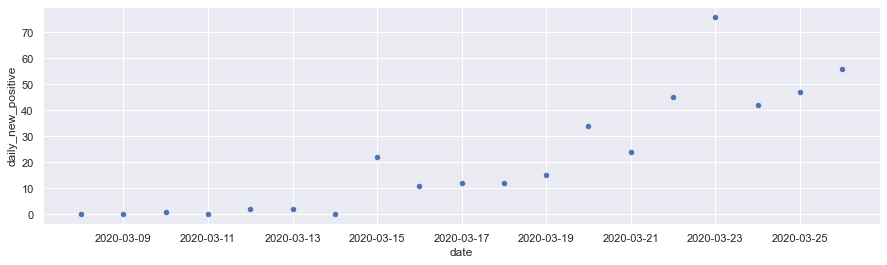

State=AR  (last_update=2020-03-27T00:00)
Doubling every 2.35 days based on last 14 days of data
(naive estimates: current_unresolved=313 hosp=46 icu=12)


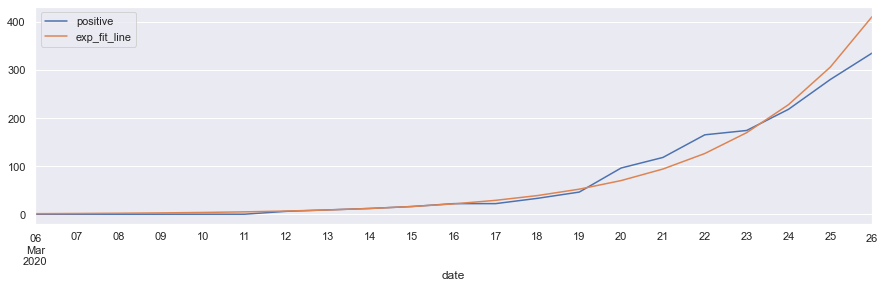

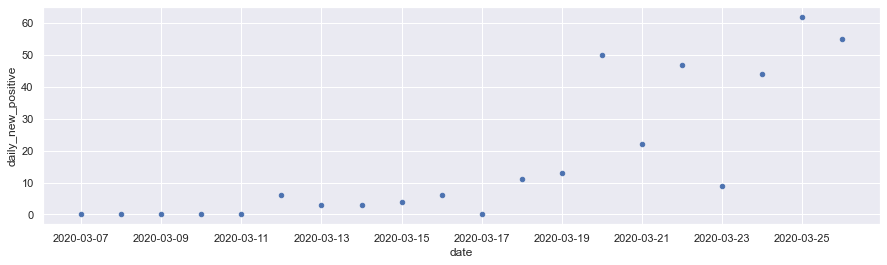

State=MN  (last_update=2020-03-26T13:15)
Doubling every 2.97 days based on last 14 days of data
(naive estimates: current_unresolved=292 hosp=43 icu=11)


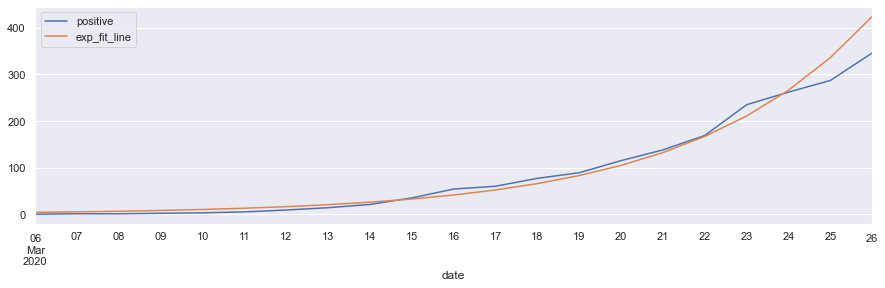

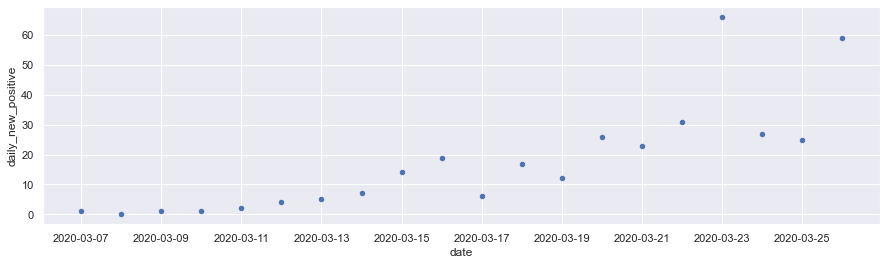

State=OR  (last_update=2020-03-26T21:46)
Doubling every 3.62 days based on last 14 days of data
(naive estimates: current_unresolved=288 hosp=43 icu=11)


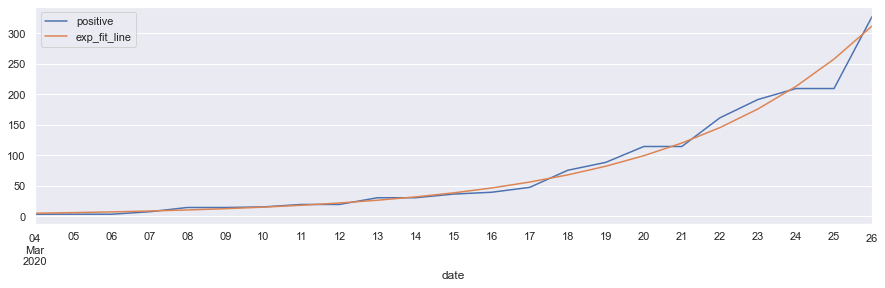

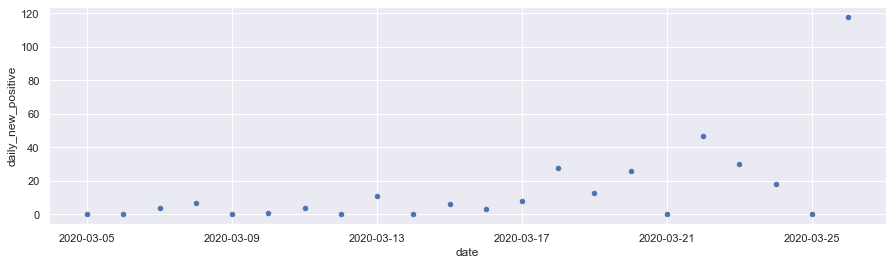

State=DC  (last_update=2020-03-26T19:00)
Doubling every 2.71 days based on last 14 days of data
(naive estimates: current_unresolved=214 hosp=32 icu=8)


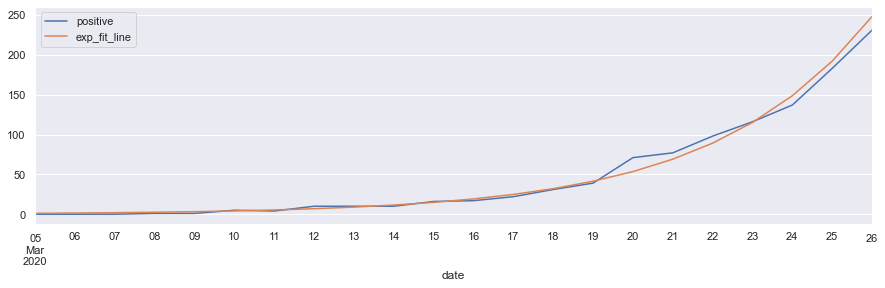

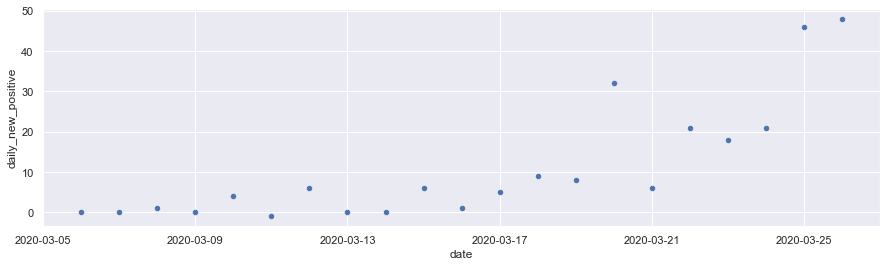

State=OK  (last_update=2020-03-26T08:00)
Doubling every 2.19 days based on last 14 days of data
(naive estimates: current_unresolved=238 hosp=35 icu=9)


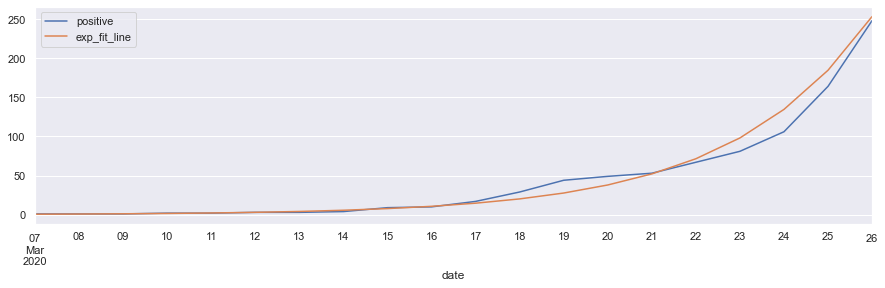

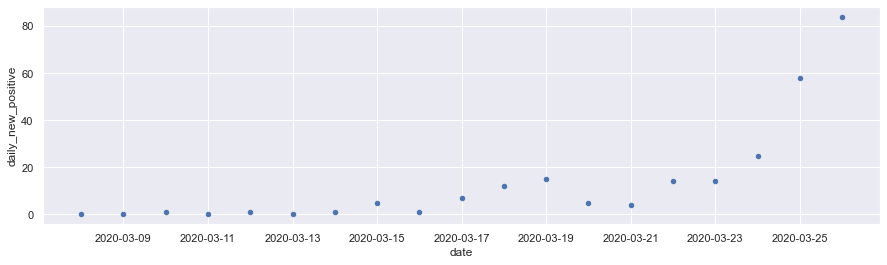

State=KY  (last_update=2020-03-26T17:00)
Doubling every 3.04 days based on last 14 days of data
(naive estimates: current_unresolved=177 hosp=26 icu=7)


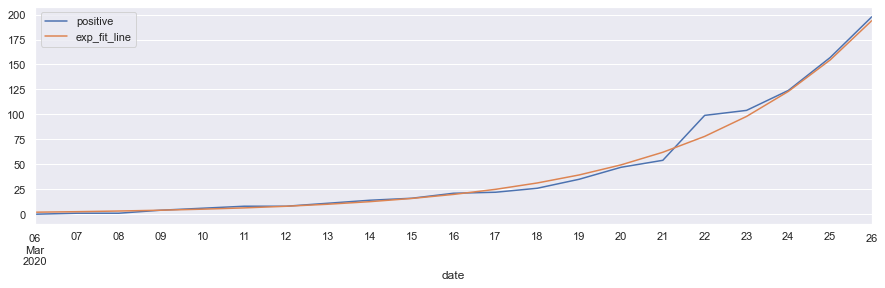

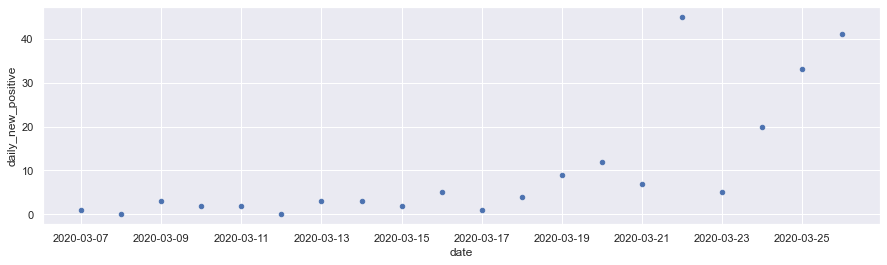

State=ID  (last_update=2020-03-26T20:00)
Doubling every 2.21 days based on last 14 days of data
(naive estimates: current_unresolved=118 hosp=17 icu=4)


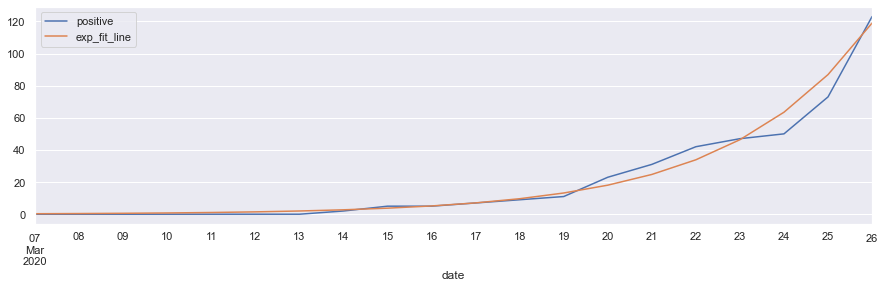

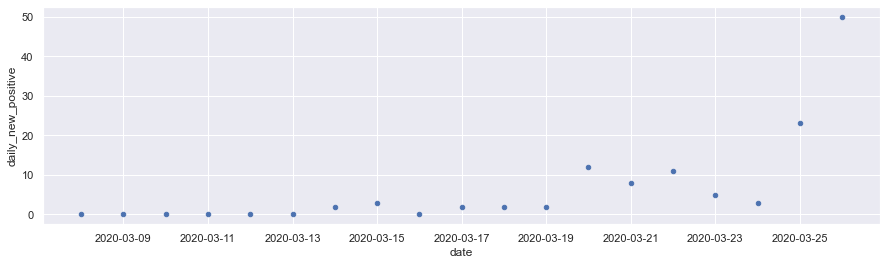

State=IA  (last_update=2020-03-26T00:00)
Doubling every 3.4 days based on last 14 days of data
(naive estimates: current_unresolved=157 hosp=23 icu=6)


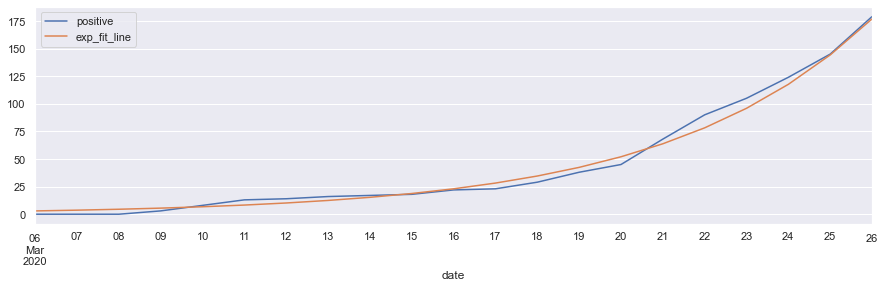

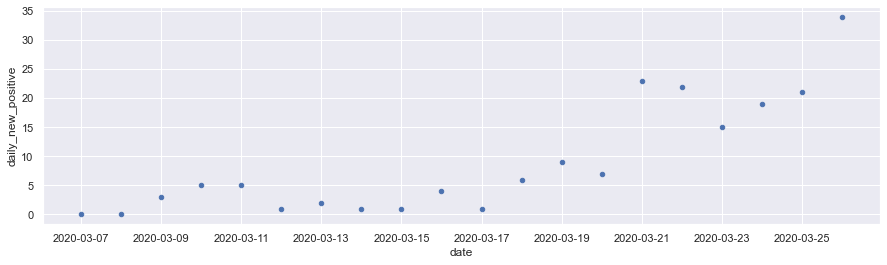

State=KS  (last_update=2020-03-26T12:00)
Doubling every 2.53 days based on last 14 days of data
(naive estimates: current_unresolved=157 hosp=23 icu=6)


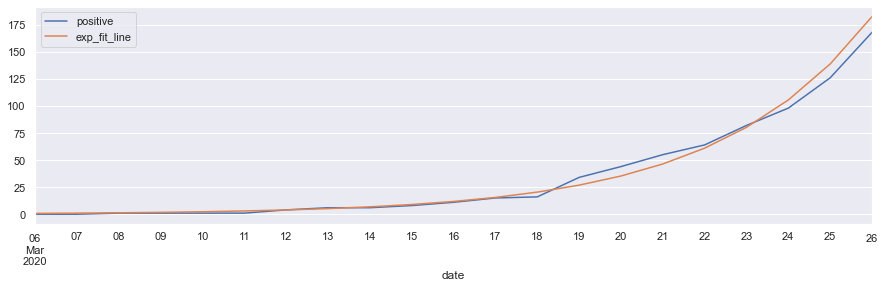

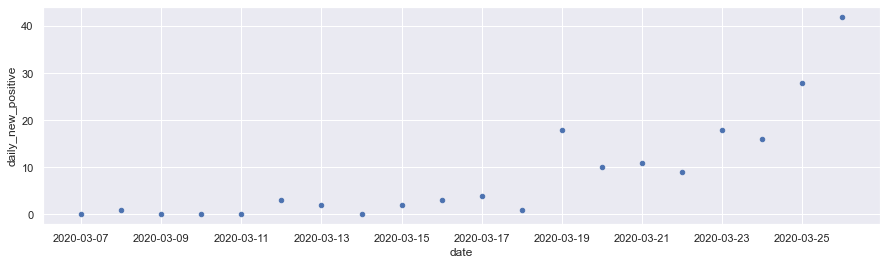

State=RI  (last_update=2020-03-26T00:00)
Doubling every 3.59 days based on last 14 days of data
(naive estimates: current_unresolved=144 hosp=21 icu=5)


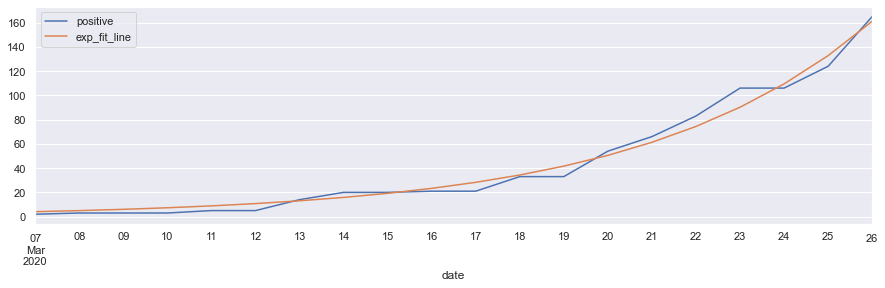

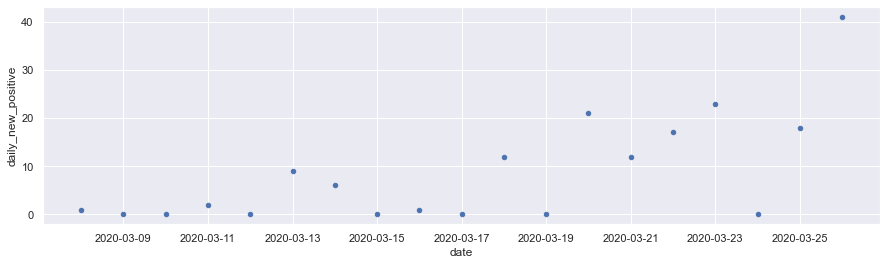

State=NH  (last_update=2020-03-26T09:00)
Doubling every 2.85 days based on last 14 days of data
(naive estimates: current_unresolved=124 hosp=18 icu=4)


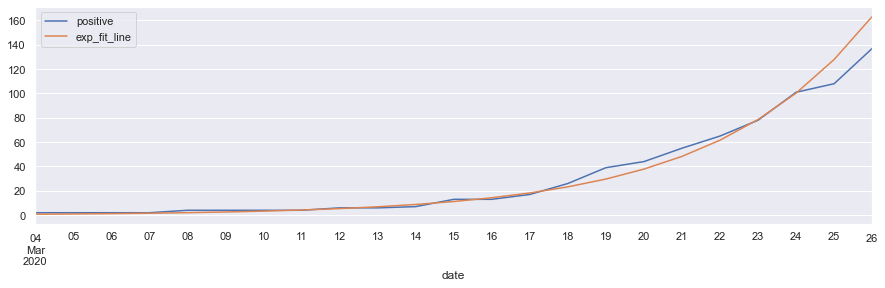

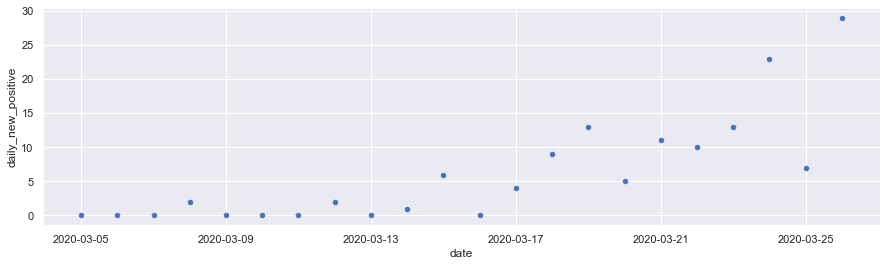

State=VT  (last_update=2020-03-26T13:00)
Doubling every 2.12 days based on last 14 days of data
(naive estimates: current_unresolved=150 hosp=22 icu=6)


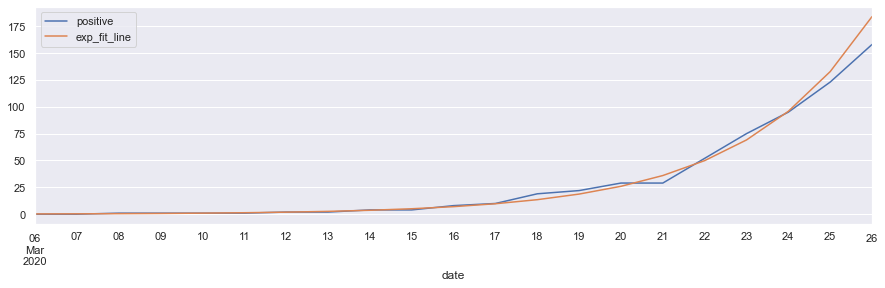

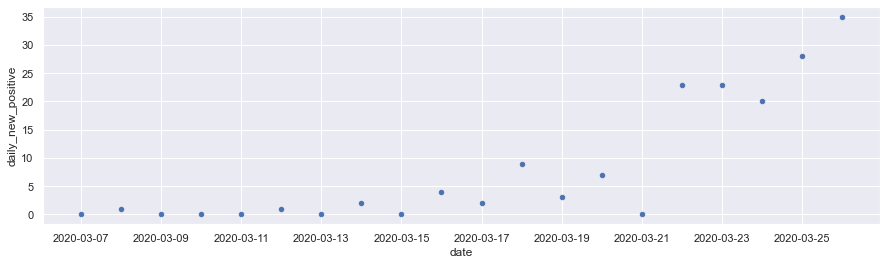

State=ME  (last_update=2020-03-26T11:00)
Doubling every 2.14 days based on last 14 days of data
(naive estimates: current_unresolved=138 hosp=20 icu=5)


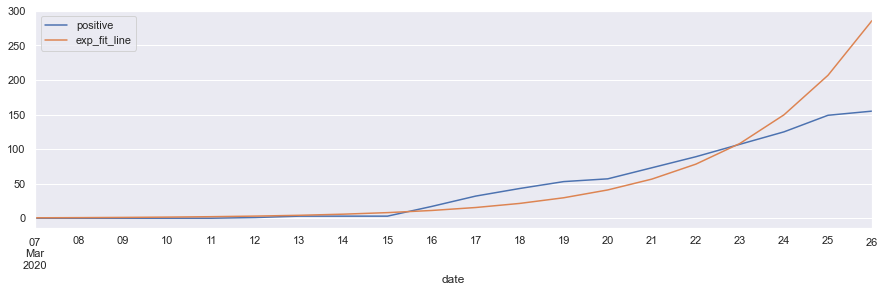

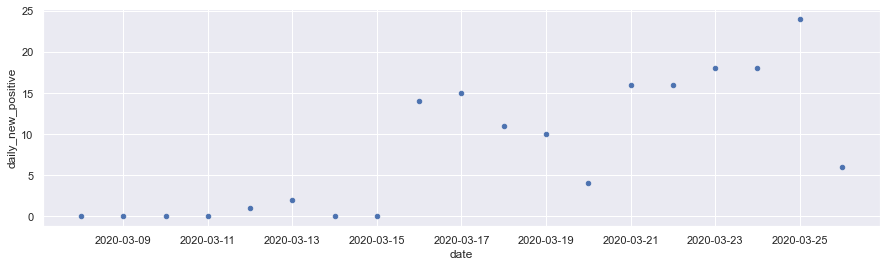

State=DE  (last_update=2020-03-26T00:00)
Doubling every 2.51 days based on last 14 days of data
(naive estimates: current_unresolved=122 hosp=18 icu=4)


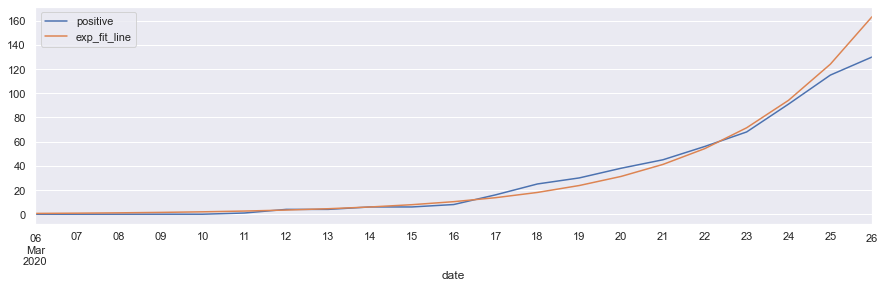

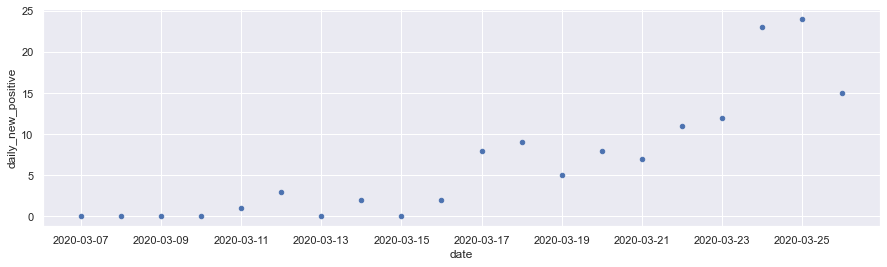

State=NM  (last_update=2020-03-26T00:00)
Doubling every 3.52 days based on last 14 days of data
(naive estimates: current_unresolved=95 hosp=14 icu=3)


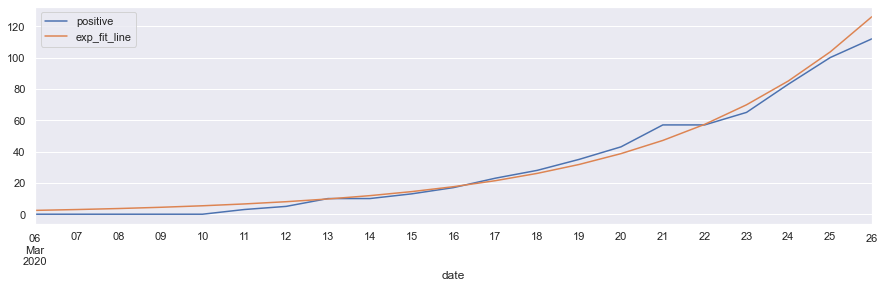

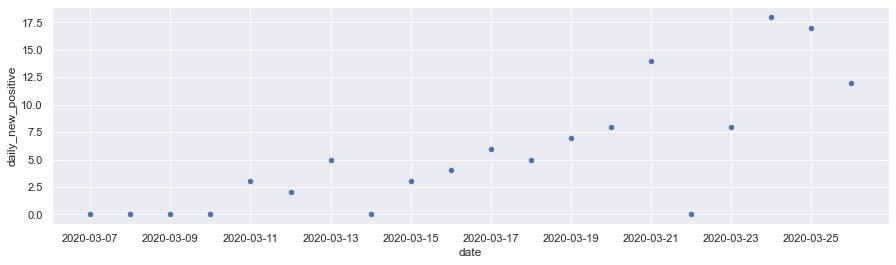

State=MT  (last_update=2020-03-27T10:00)
Doubling every 2.66 days based on last 14 days of data
(naive estimates: current_unresolved=64 hosp=9 icu=2)


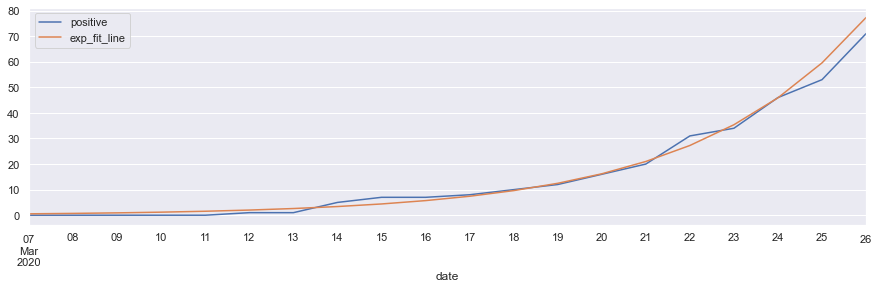

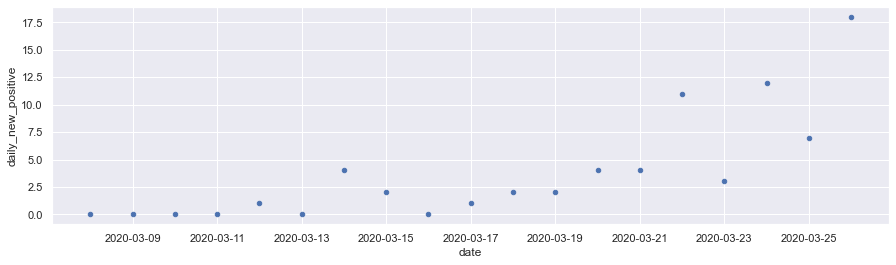

State=HI  (last_update=2020-03-26T18:00)
Doubling every 2.09 days based on last 14 days of data
(naive estimates: current_unresolved=88 hosp=13 icu=3)


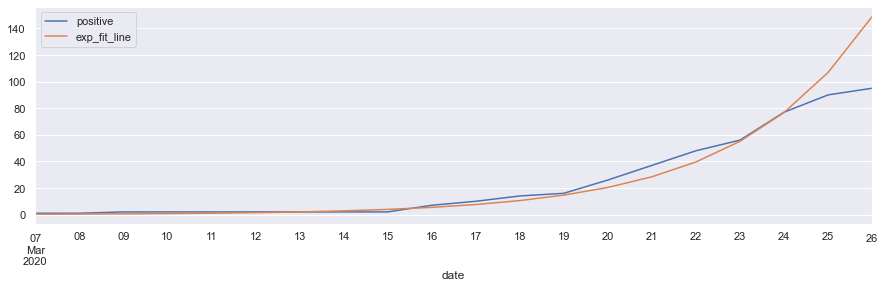

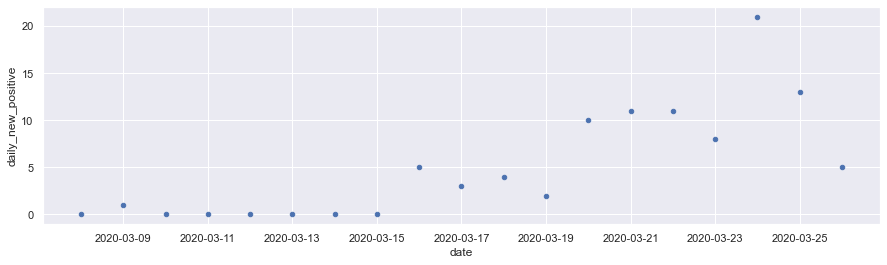

State=WV  (last_update=2020-03-26T00:00)
Doubling every 1.53 days based on last 14 days of data
(naive estimates: current_unresolved=51 hosp=7 icu=2)


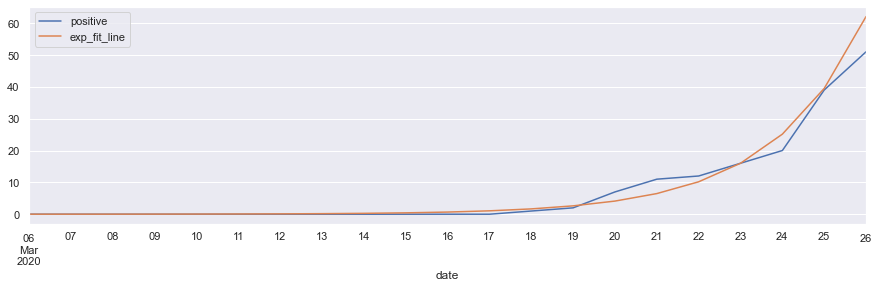

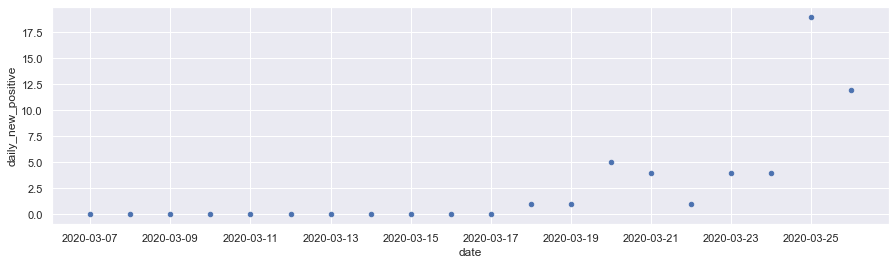

State=NE  (last_update=2020-03-26T14:00)
Doubling every 5.13 days based on last 14 days of data
(naive estimates: current_unresolved=55 hosp=8 icu=2)


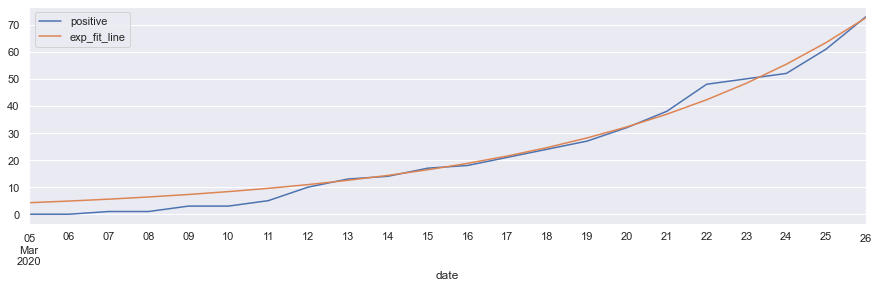

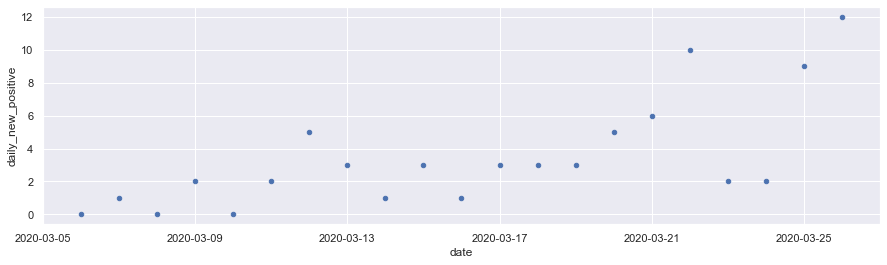

State=AK  (last_update=2020-03-26T21:00)
Doubling every 1.96 days based on last 14 days of data
(naive estimates: current_unresolved=58 hosp=8 icu=2)


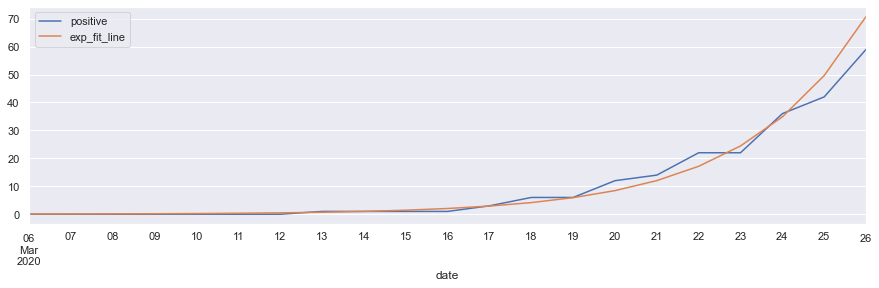

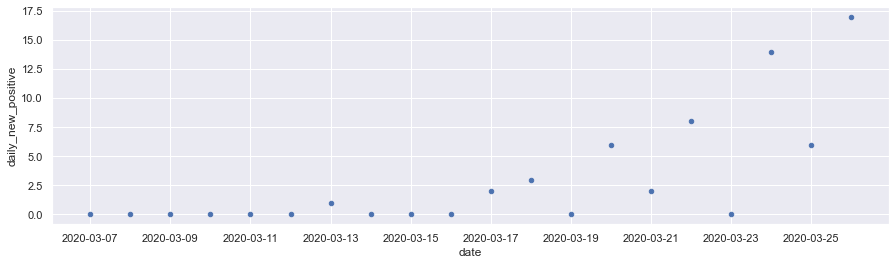

State=PR  (last_update=2020-03-26T07:00)
Doubling every 2.36 days based on last 14 days of data
(naive estimates: current_unresolved=59 hosp=8 icu=2)


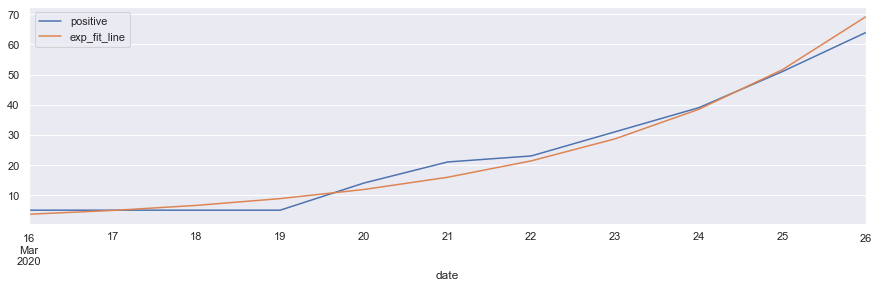

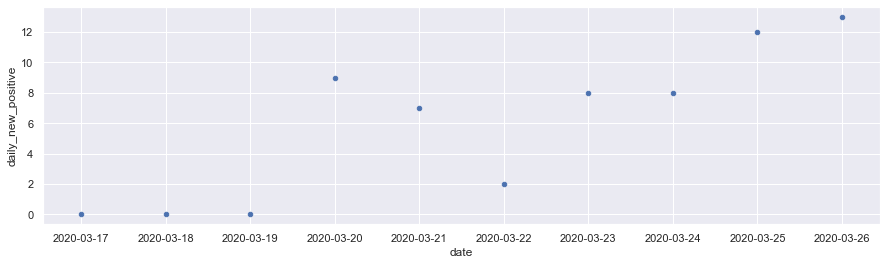

State=ND  (last_update=2020-03-26T17:34)
Doubling every 1.93 days based on last 14 days of data
(naive estimates: current_unresolved=51 hosp=7 icu=2)


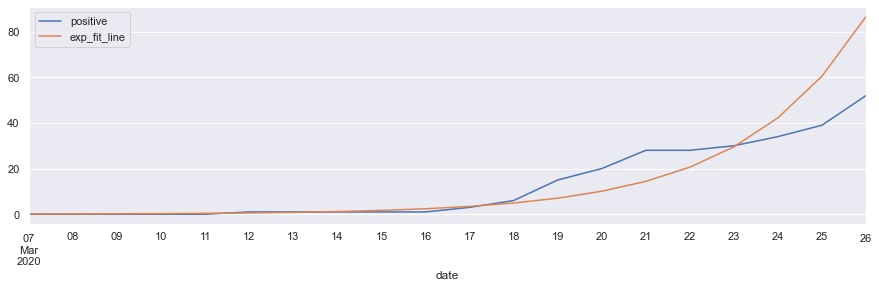

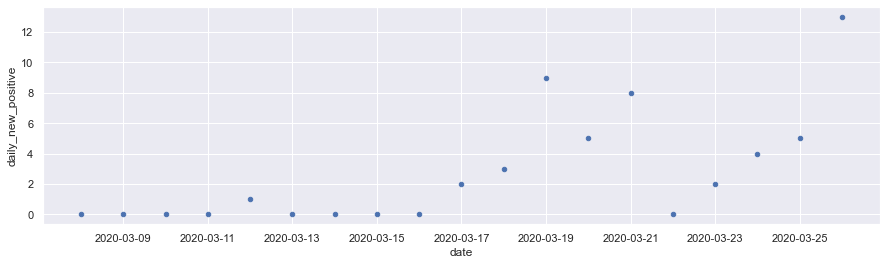

State=WY  (last_update=2020-03-26T21:00)
Doubling every 2.49 days based on last 14 days of data
(naive estimates: current_unresolved=50 hosp=7 icu=2)


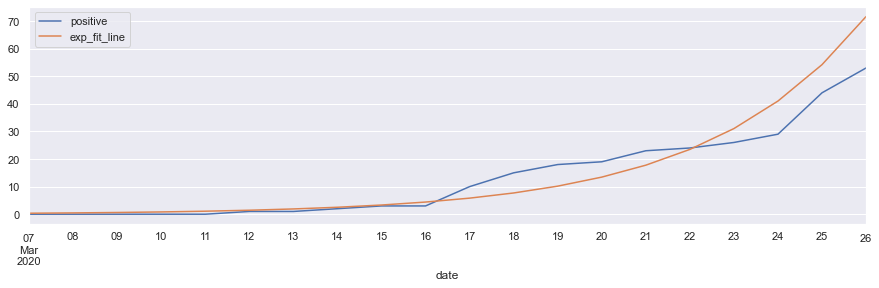

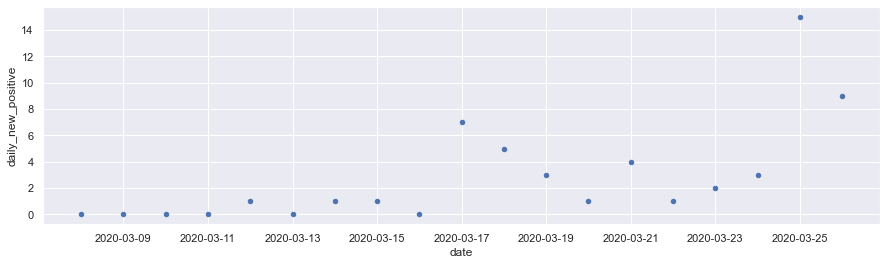

State=GU  (last_update=2020-03-27T07:00)
Doubling every 2.71 days based on last 14 days of data
(naive estimates: current_unresolved=42 hosp=6 icu=1)


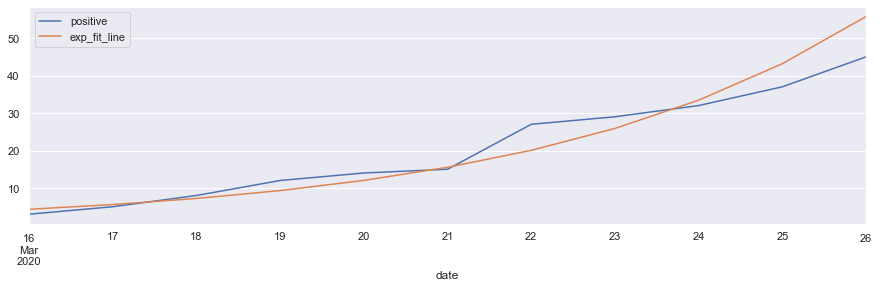

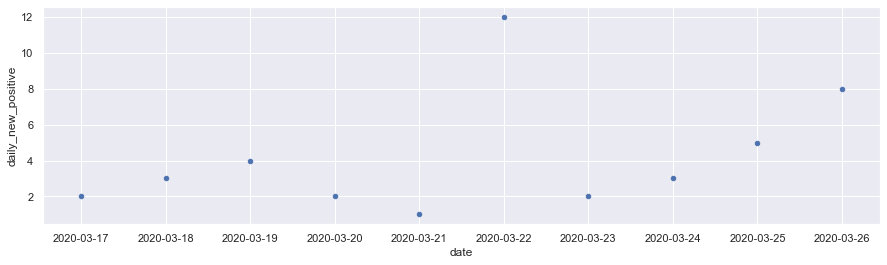

State=SD  (last_update=2020-03-25T13:00)
Doubling every 5.25 days based on last 14 days of data
(naive estimates: current_unresolved=36 hosp=5 icu=1)


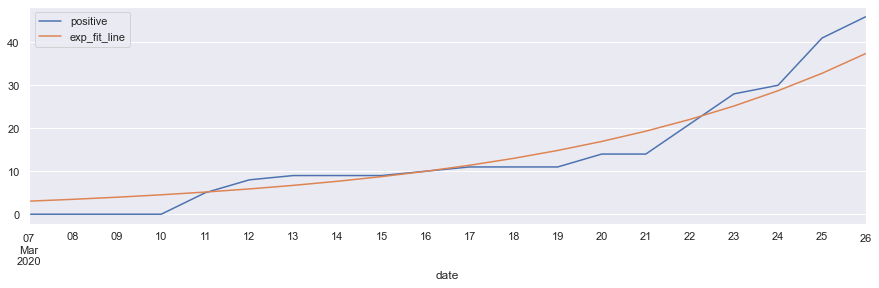

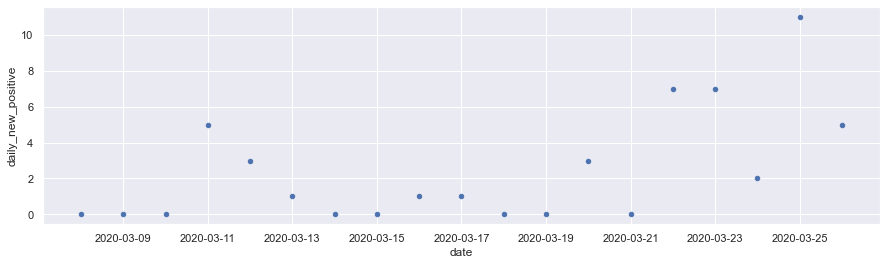

State=VI  (last_update=2020-03-26T20:30)
Doubling every 2.29 days based on last 14 days of data
(naive estimates: current_unresolved=16 hosp=2 icu=0)


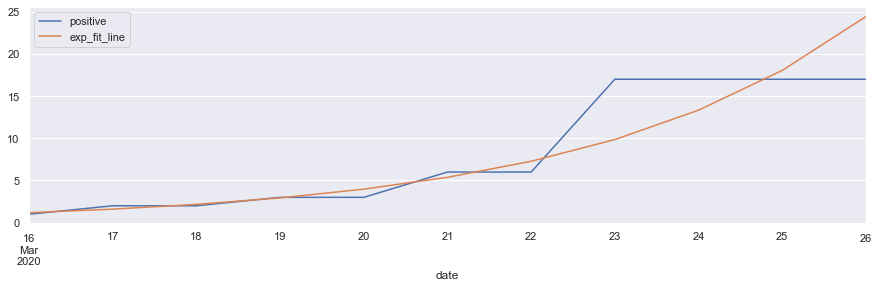

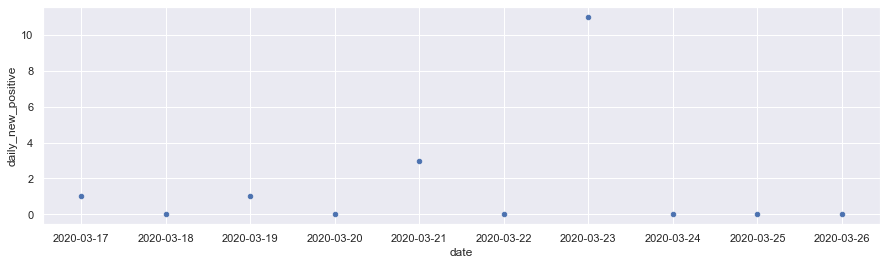

State=AS  (last_update=2020-03-27T00:00)
Doubling every nan days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


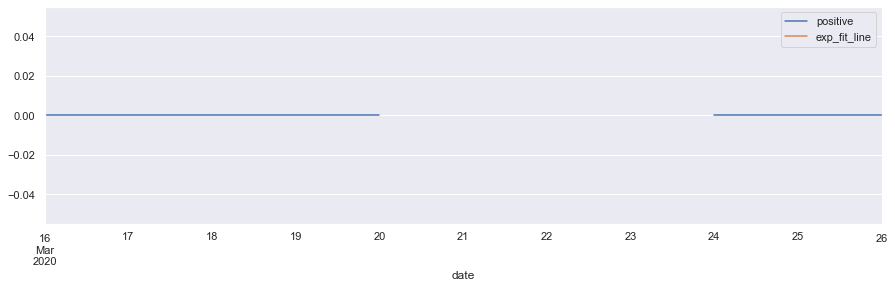

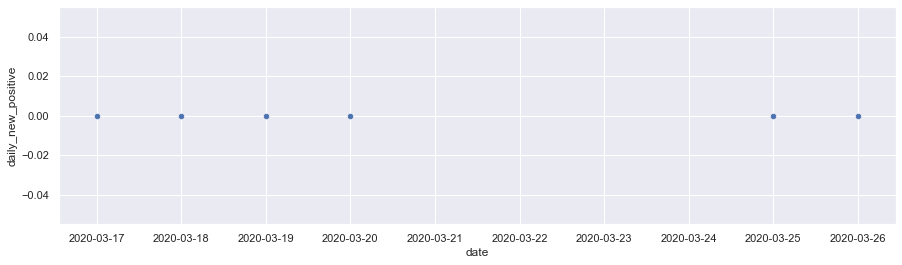

State=MP  (last_update=2020-03-26T18:30)
Doubling every 6.93e+09 days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


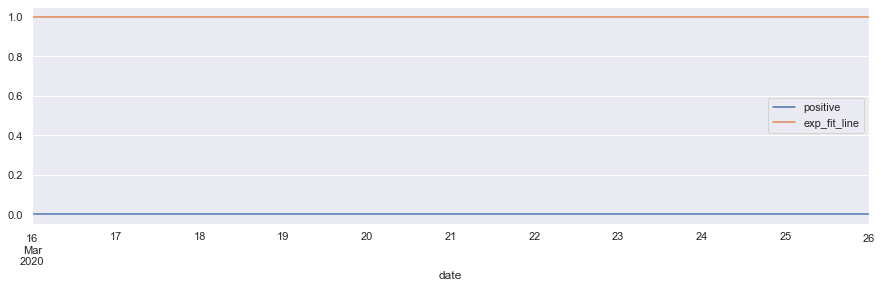

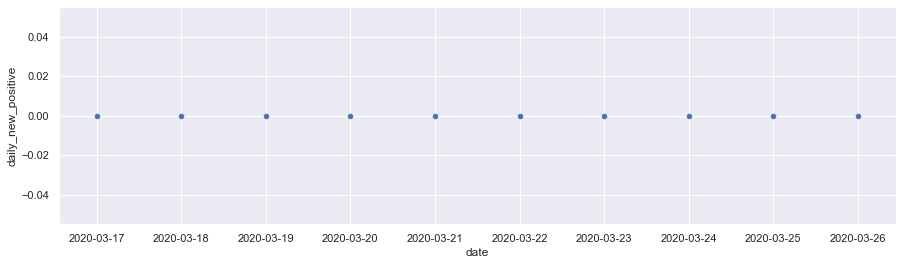

In [14]:
last_n_days = 14
dps = []
for s in states_in_order:
    dfq, dt, lud = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    cn, cnh, cni = estimate_current_cases(dfq.daily_new_positive.values)
    lu = str(lud)[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    print("(naive estimates: current_unresolved={} hosp={} icu={})".format(cn, cnh, cni))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
    plt.show()

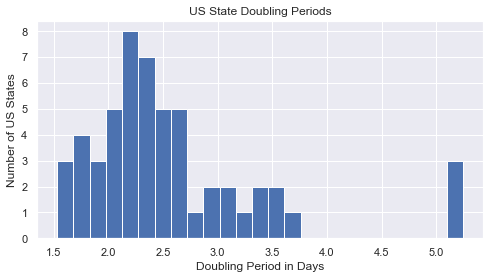

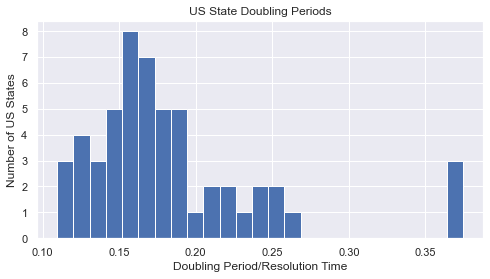

In [15]:
plt.figure(figsize=[8,4])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 30]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[8,4])
resolution_time = 14
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period for US

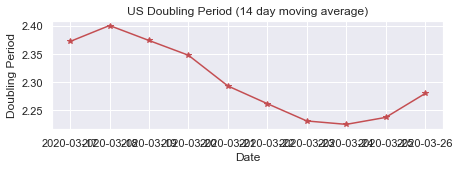

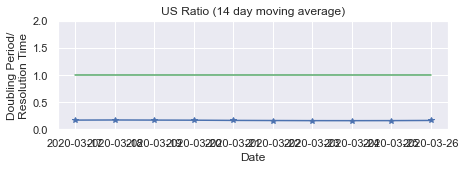

In [16]:
window_size = 14 # days
start_date, end_date = df.date.min(), df.date.max()
delta_t = pd.Timedelta(days=1)
days = int((end_date - start_date).days)
dtv = []
dtt = []
for i in range(days-window_size+2):
    sdt = start_date + i * delta_t
    edt = sdt + window_size * delta_t
    _df = df.loc[(df.date >= sdt) & (df.date < edt)].copy()
    dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
    dtv.append(dt)
    dtt.append(_df.date.values[-1])
plt.figure(figsize=[7,2])
plt.plot(dtt, dtv, "*r-")
plt.title("US Doubling Period ({} day moving average)".format(window_size))
plt.ylabel("Doubling Period")
plt.xlabel("Date")
plt.show()
# by ratio
plt.figure(figsize=[7,2])
plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
plt.plot(dtt, np.ones(len(dtt)), "g")
plt.title("US Ratio ({} day moving average)".format(window_size))
plt.ylim((0,2))
plt.ylabel("Doubling Period/\nResolution Time")
plt.xlabel("Date")
plt.show()

### Rolling Doubling Period World

In [17]:
def period_factor_plot(dfw, code="CHN", window_size=14, resolution_time=14, ylimit=7):
    dfq, _ = get_state_df(dfw, code)
    try:
        state_name = dfq.Entity.values[0]
    except AttributeError:
        if code == "*":
            state_name = "US"
        else:
            state_name = code
    start_date, end_date = dfq.date.min(), dfq.date.max()
    delta_t = pd.Timedelta(days=1)
    days = int((end_date - start_date).days)
    dtv, dtt = [], []
    for i in range(days-window_size+2):
        sdt = start_date + i * delta_t
        edt = sdt + window_size * delta_t
        _df = dfq.loc[(dfq.date >= sdt) & (dfq.date < edt)].copy()
        dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
        dtv.append(dt)
        dtt.append(_df.date.values[-1])
    plt.figure(figsize=[7,2])
    plt.ylim((0,min([100, 1.1*max(dtv)])))
    plt.plot(dtt, dtv, "*r-")
    plt.title("{} Doubling Period ({} day moving average)".format(state_name, window_size))
    plt.ylabel("Doubling Period")
    plt.xlabel("Date")
    plt.show()
    # by ratio
    plt.figure(figsize=[7,2])
    plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
    plt.plot(dtt, np.ones(len(dtt)), "g")
    plt.fill_between(dtt, np.ones(len(dtt))*3, np.ones(len(dtt))*5, where=np.ones(len(dtt)), color="yellow", alpha=0.1)
    plt.fill_between(dtt, np.ones(len(dtt))*5, np.ones(len(dtt))*ylimit, where=np.ones(len(dtt)), color="yellow", alpha=0.05)
    plt.fill_between(dtt, np.zeros(len(dtt)), np.ones(len(dtt))*3, where=np.ones(len(dtt)), color="red", alpha=0.1)
    plt.title("{} Ratio ({} day moving average)".format(state_name, window_size))
    plt.ylim((0,ylimit))
    plt.ylabel("Doubling Period/\nResolution Time")
    plt.xlabel("Date")
    plt.show()
    

In [24]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

,Entity,state,Date,positive,date,lastUpdateEt,negative,pending
0,Afghanistan,AFG,"Dec 31, 2019",0,2019-12-31,2020-03-27 20:04:47.564762,0,0
1,Afghanistan,AFG,"Jan 1, 2020",0,2020-01-01,2020-03-27 20:04:47.564762,0,0
2,Afghanistan,AFG,"Jan 2, 2020",0,2020-01-02,2020-03-27 20:04:47.564762,0,0
3,Afghanistan,AFG,"Jan 3, 2020",0,2020-01-03,2020-03-27 20:04:47.564762,0,0
4,Afghanistan,AFG,"Jan 4, 2020",0,2020-01-04,2020-03-27 20:04:47.564762,0,0


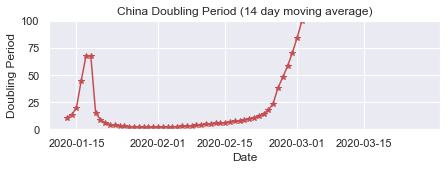

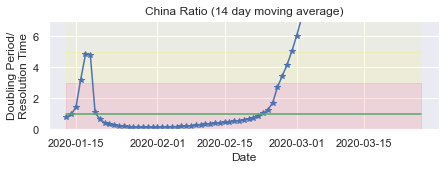

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


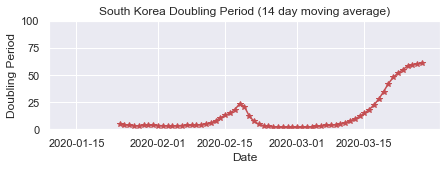

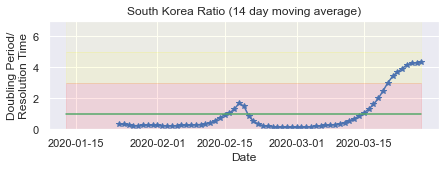

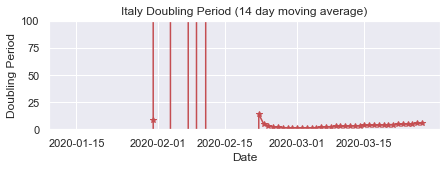

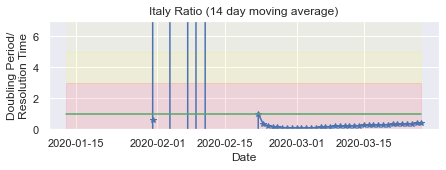

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


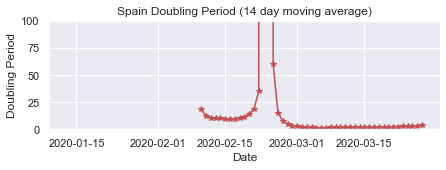

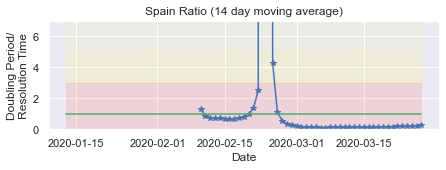

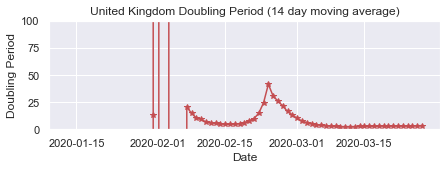

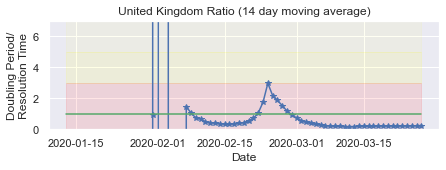

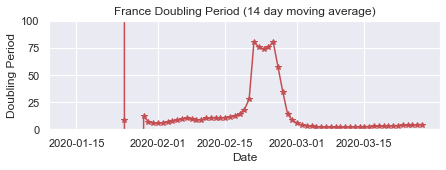

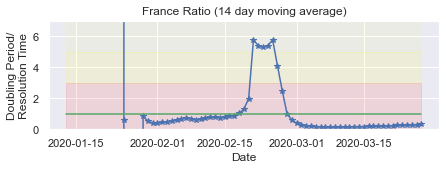

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


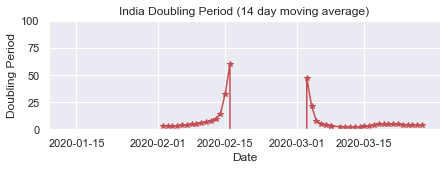

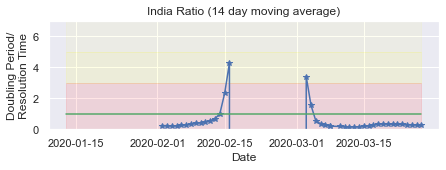

In [25]:
period_factor_plot(dfw,"CHN")
period_factor_plot(dfw,"KOR")
period_factor_plot(dfw,"ITA")
period_factor_plot(dfw,"ESP")
period_factor_plot(dfw,"GBR")
period_factor_plot(dfw,"FRA")
period_factor_plot(dfw,"IND")

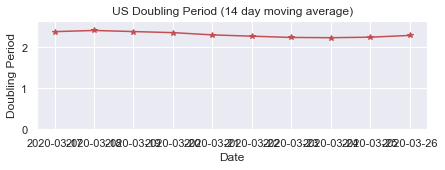

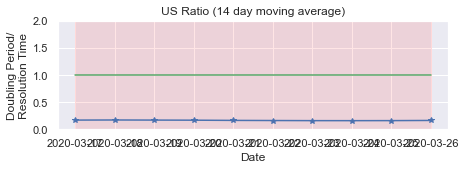

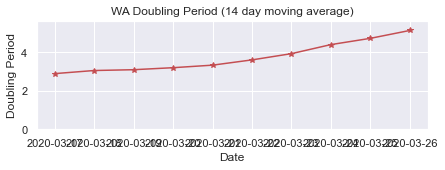

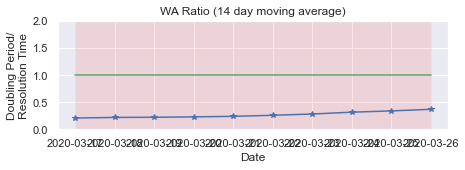

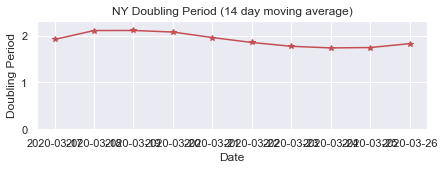

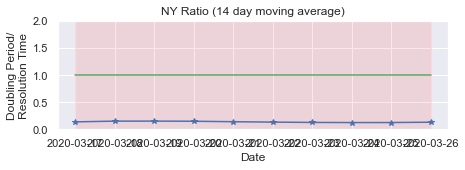

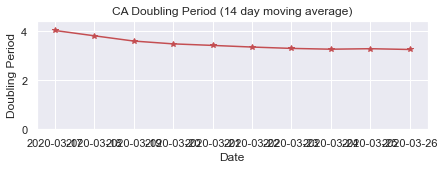

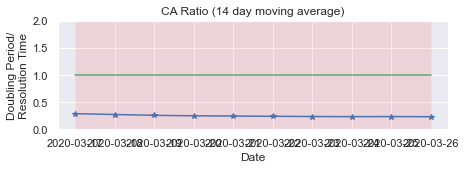

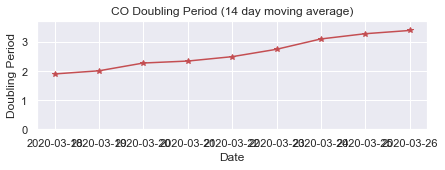

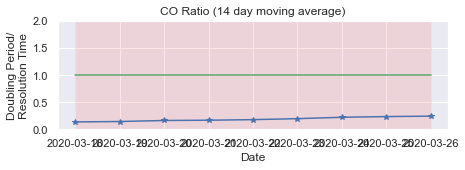

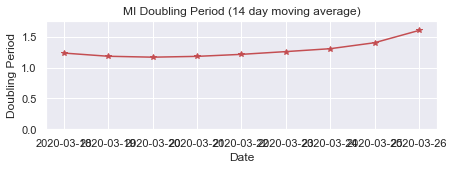

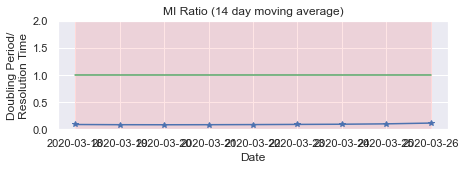

In [20]:
dfw, _ = get_state_df(df, "*")
period_factor_plot(dfw,"*", ylimit=2)
dfw, _ = get_state_df(df, "WA")
period_factor_plot(dfw,"WA", ylimit=2)
dfw, _ = get_state_df(df, "NY")
period_factor_plot(dfw,"NY", ylimit=2)
dfw, _ = get_state_df(df, "CA")
period_factor_plot(dfw,"CA", ylimit=2)
dfw, _ = get_state_df(df, "CO")
period_factor_plot(dfw,"CO", ylimit=2)
dfw, _ = get_state_df(df, "MI")
period_factor_plot(dfw,"MI", ylimit=2)

### Big Grid of Daily Total Cases by State

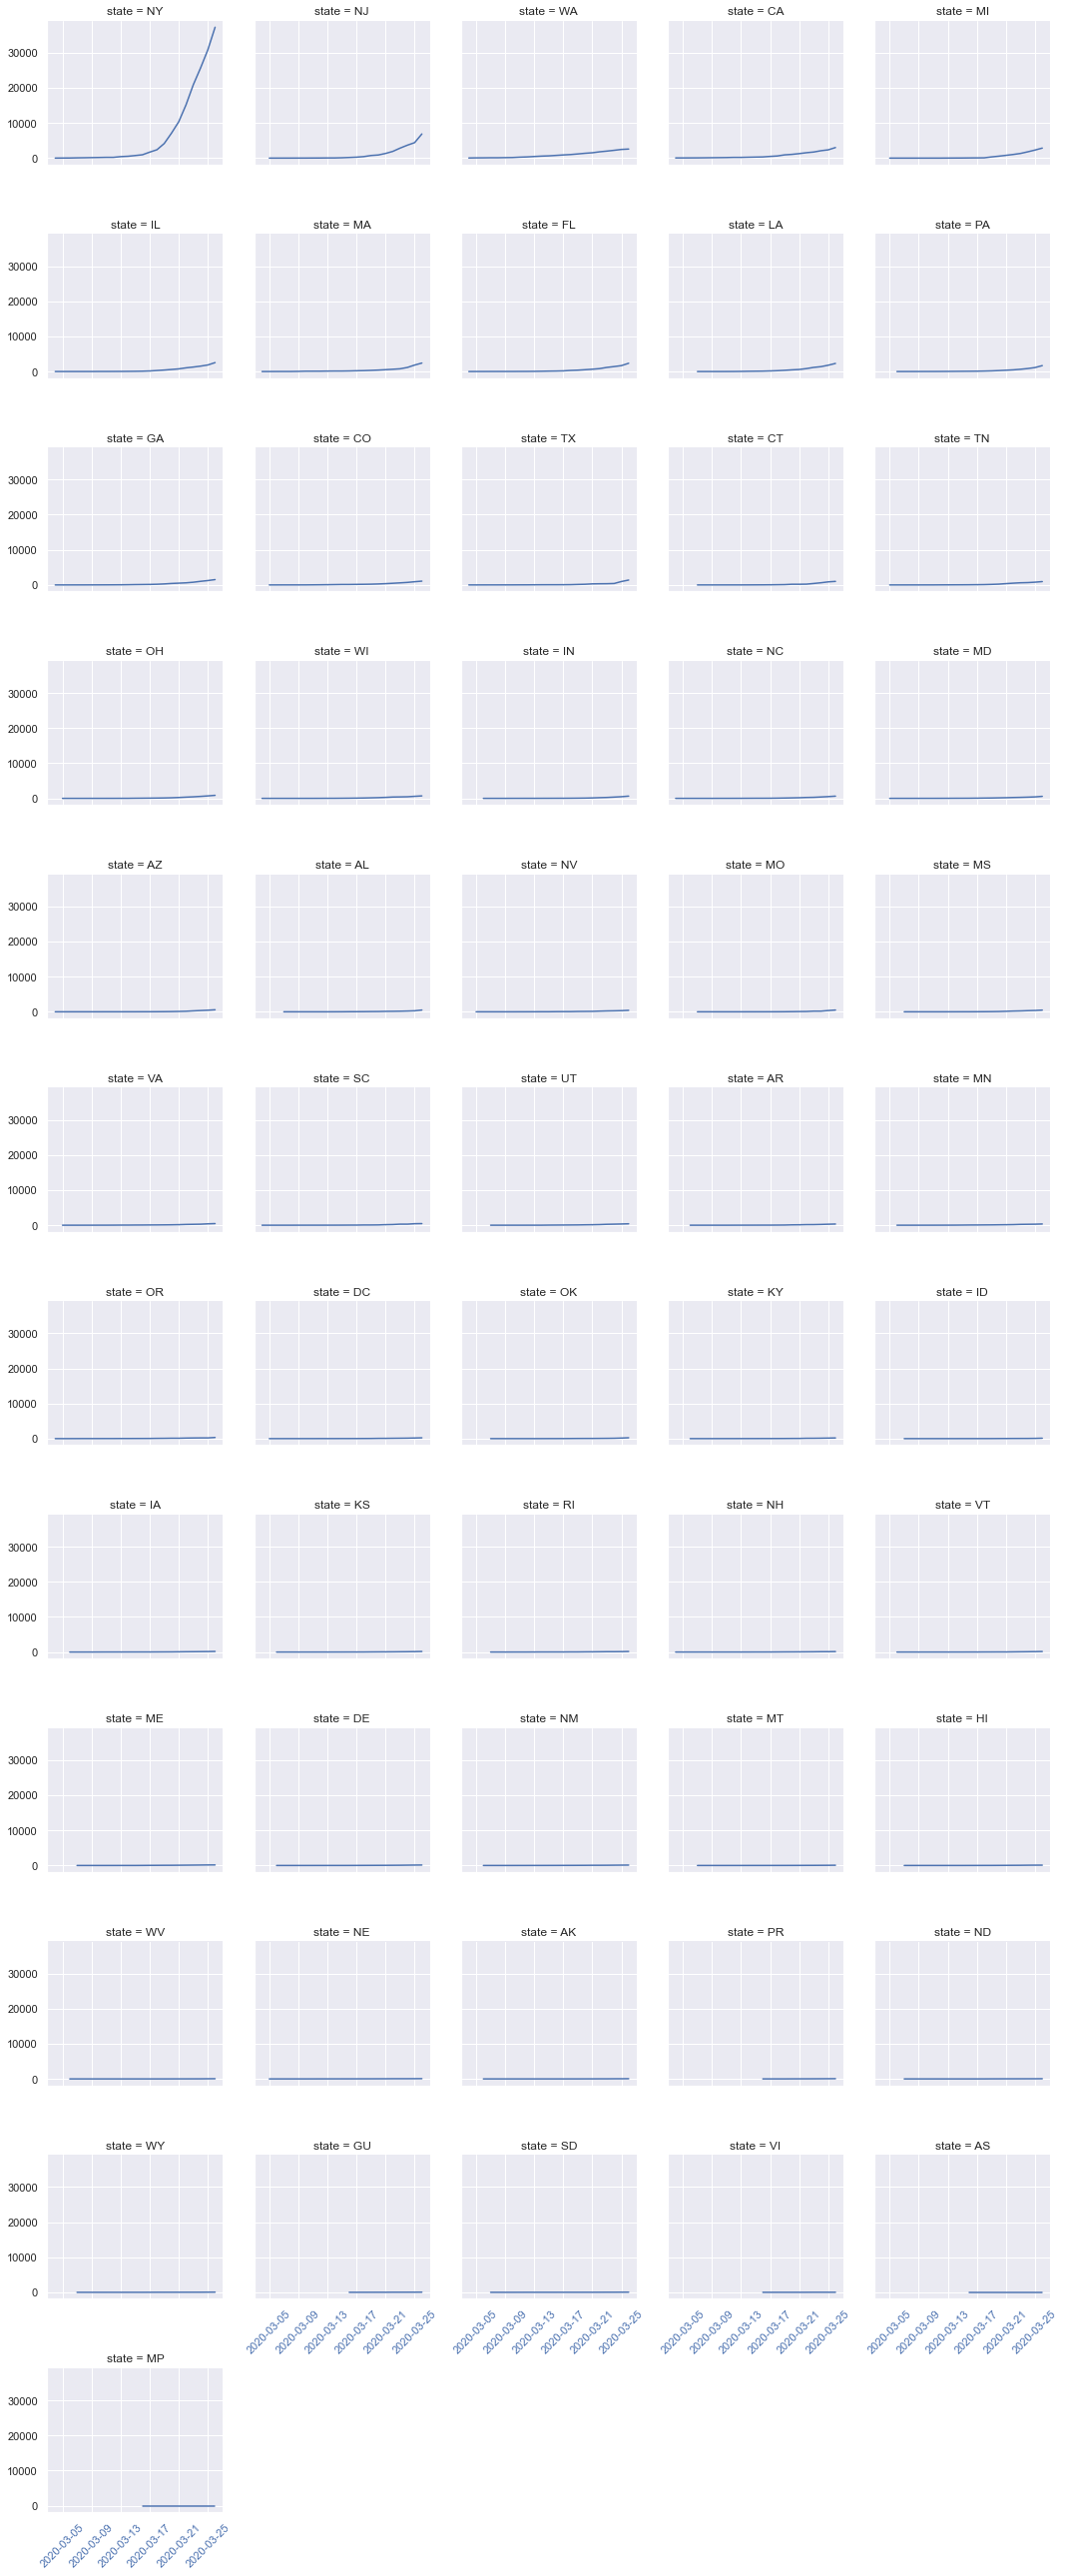

In [21]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)